In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, confusion_matrix
)
from scipy.stats import spearmanr
import os

In [23]:
# ===============================================================
# 🏆 INDIVIDUAL AWARDS PREDICTION — DATA PREPARATION
# ===============================================================

# ===============================================================
# 1️⃣ Load Data
# ===============================================================
players = pd.read_csv("data/players.csv")
players_teams = pd.read_csv("data/players_teams.csv")
awards = pd.read_csv("data/awards_players.csv")
teams = pd.read_csv("data/teams.csv")

# ===============================================================
# 2️⃣ Filter to main awards only
# ===============================================================
main_awards = [
    'Most Valuable Player',
    'Defensive Player of the Year',
    'Rookie of the Year'
]
awards_main = awards[awards['award'].isin(main_awards)]

print(f"Total awards: {len(awards_main)}")
print(awards_main['award'].value_counts())

# ===============================================================
# 3️⃣ Create player performance features
# ===============================================================
player_stats = players_teams.copy()

# Filter players with significant playing time (>= 10 games)
player_stats = player_stats[player_stats['GP'] >= 10]

# Per-game statistics
player_stats['ppg'] = player_stats['points'] / player_stats['GP']
player_stats['rpg'] = player_stats['rebounds'] / player_stats['GP']
player_stats['apg'] = player_stats['assists'] / player_stats['GP']
player_stats['spg'] = player_stats['steals'] / player_stats['GP']
player_stats['bpg'] = player_stats['blocks'] / player_stats['GP']
player_stats['mpg'] = player_stats['minutes'] / player_stats['GP']

# Shooting efficiency
player_stats['fg_pct'] = np.where(
    player_stats['fgAttempted'] > 0,
    player_stats['fgMade'] / player_stats['fgAttempted'],
    0
)

# Simple efficiency rating
player_stats['efficiency'] = (
    player_stats['points'] + player_stats['rebounds'] + 
    player_stats['assists'] + player_stats['steals'] + 
    player_stats['blocks'] - player_stats['turnovers']
) / player_stats['GP']

# Games started percentage
player_stats['gs_pct'] = player_stats['GS'] / player_stats['GP']

# ===============================================================
# 4️⃣ Add team success metrics
# ===============================================================
teams_success = teams[['year', 'tmID', 'won', 'lost', 'confID', 'playoff']].copy()
teams_success['win_pct'] = teams_success['won'] / (teams_success['won'] + teams_success['lost'])
teams_success['made_playoffs'] = teams_success['playoff'].notna().astype(int)

# Add conference rank (important for awards context)
teams_success['conf_rank'] = teams_success.groupby(['year', 'confID'])['win_pct'].rank(ascending=False)

player_stats = player_stats.merge(teams_success[['year', 'tmID', 'win_pct', 'made_playoffs', 'conf_rank']], 
                                   on=['year', 'tmID'], how='left')

# ===============================================================
# 4b️⃣ Add league-wide comparative metrics
# ===============================================================
# Calculate league averages per year
yearly_avg = player_stats.groupby('year').agg({
    'ppg': 'mean',
    'rpg': 'mean',
    'apg': 'mean',
    'spg': 'mean',
    'bpg': 'mean',
    'efficiency': 'mean'
}).add_suffix('_league_avg').reset_index()

player_stats = player_stats.merge(yearly_avg, on='year', how='left')

# Create comparative features (how much better than average)
player_stats['ppg_vs_avg'] = player_stats['ppg'] - player_stats['ppg_league_avg']
player_stats['rpg_vs_avg'] = player_stats['rpg'] - player_stats['rpg_league_avg']
player_stats['apg_vs_avg'] = player_stats['apg'] - player_stats['apg_league_avg']
player_stats['efficiency_vs_avg'] = player_stats['efficiency'] - player_stats['efficiency_league_avg']

# ===============================================================
# 5️⃣ Identify rookies (first year players)
# ===============================================================
player_stats = player_stats.sort_values(['playerID', 'year'])
player_stats['is_rookie'] = player_stats.groupby('playerID').cumcount() == 0
player_stats['is_rookie'] = player_stats['is_rookie'].astype(int)

# ===============================================================
# 6️⃣ Create target variables for each award
# ===============================================================
for award in main_awards:
    col_name = f"won_{award.replace(' ', '_').lower()}"
    player_stats[col_name] = 0
    
    for _, row in awards_main[awards_main['award'] == award].iterrows():
        mask = (player_stats['playerID'] == row['playerID']) & \
               (player_stats['year'] == row['year'])
        player_stats.loc[mask, col_name] = 1

# ===============================================================
# 7️⃣ Fill missing values
# ===============================================================
player_stats['win_pct'] = player_stats['win_pct'].fillna(0.5)
player_stats['made_playoffs'] = player_stats['made_playoffs'].fillna(0)
player_stats['conf_rank'] = player_stats['conf_rank'].fillna(8)  # Middle of conference
for col in ['ppg_vs_avg', 'rpg_vs_avg', 'apg_vs_avg', 'efficiency_vs_avg']:
    player_stats[col] = player_stats[col].fillna(0)

# ===============================================================
# 8️⃣ Save prepared dataset
# ===============================================================
os.makedirs("data_models", exist_ok=True)
player_stats.to_csv("data_models/awards_dataset.csv", index=False)

print("\n✅ Dataset ready: data_models/awards_dataset.csv")
print(f"Shape: {player_stats.shape}")
print("\nAward winners distribution:")
for award in main_awards:
    col_name = f"won_{award.replace(' ', '_').lower()}"
    winners = player_stats[col_name].sum()
    print(f"{award}: {winners} winners")

Total awards: 30
award
Defensive Player of the Year    10
Most Valuable Player            10
Rookie of the Year              10
Name: count, dtype: int64

✅ Dataset ready: data_models/awards_dataset.csv
Shape: (1603, 69)

Award winners distribution:
Most Valuable Player: 10 winners
Defensive Player of the Year: 10 winners
Rookie of the Year: 10 winners


Treino: (1458, 69) | Teste (10): (145, 69)

MVP winners in training: 9
MVP winners in test: 1
Class balance: 9/1458 = 0.62%

📊 MVP Ranking Evaluation for year 10:
Actual winner rank: 1 out of 145
Actual winner probability: 0.585
Top-1 prediction: ✓ CORRECT
Top-3 prediction: ✓ CORRECT
Top-5 prediction: ✓ CORRECT
Top-10 prediction: ✓ CORRECT
Mean Reciprocal Rank: 1.0000
Spearman Rank Correlation: 0.3161 (p=0.0001)

📌 Baseline Comparison:
Baseline strategy: Rank by efficiency (simple heuristic)
  Baseline model ranks winner at: #1
  Our model ranks winner at: #1
  Improvement: 0 positions worse

🏆 Top 10 MVP candidates:
        playerID tmID        ppg   win_pct  made_playoffs  mvp_proba  \
1362  tauradi01w  PHO  20.354839  0.676471              1      0.585   
1099  pondeca01w  PHO  19.058824  0.676471              1      0.090   
630   jacksla01w  SEA  19.192308  0.588235              1      0.050   
1596  youngso01w  SAS  18.181818  0.441176              1      0.010   
1054  parkeca01

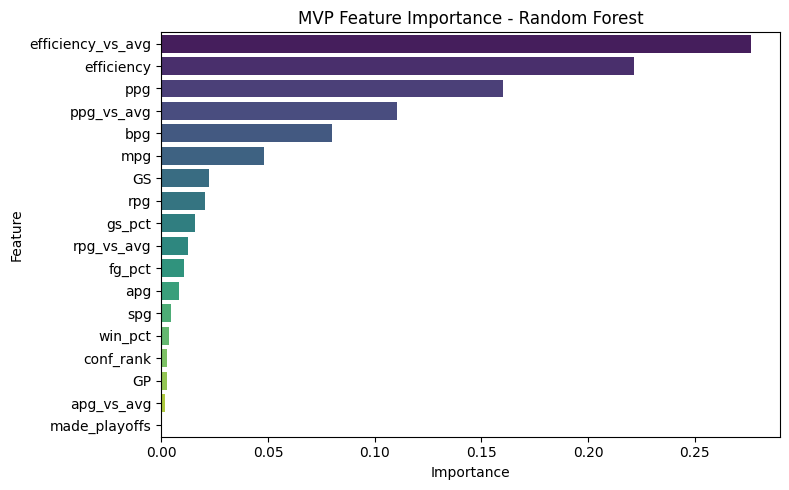


💡 Top 5 Most Important Features:
              Feature  Importance
17  efficiency_vs_avg    0.276160
7          efficiency    0.221538
0                 ppg    0.160275
14         ppg_vs_avg    0.110432
4                 bpg    0.079745


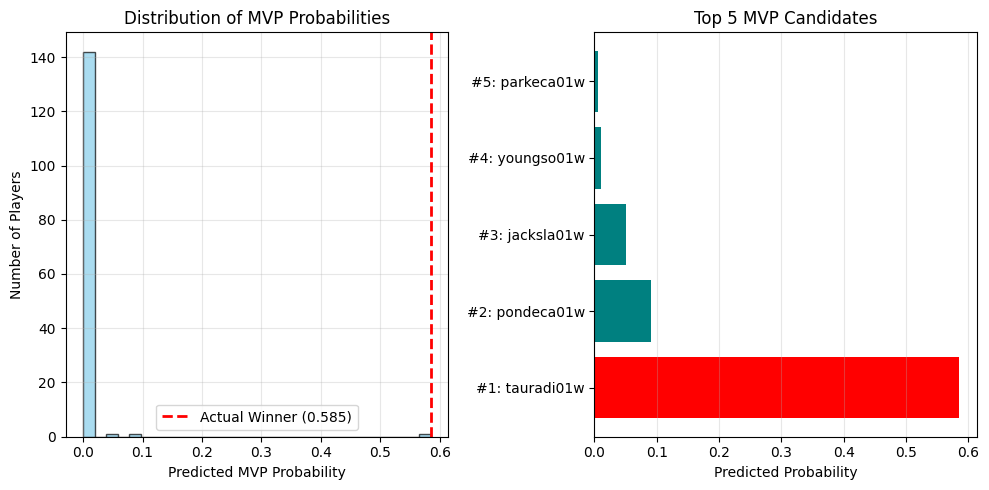


✅ Results saved to: data_models/predictions_mvp.csv


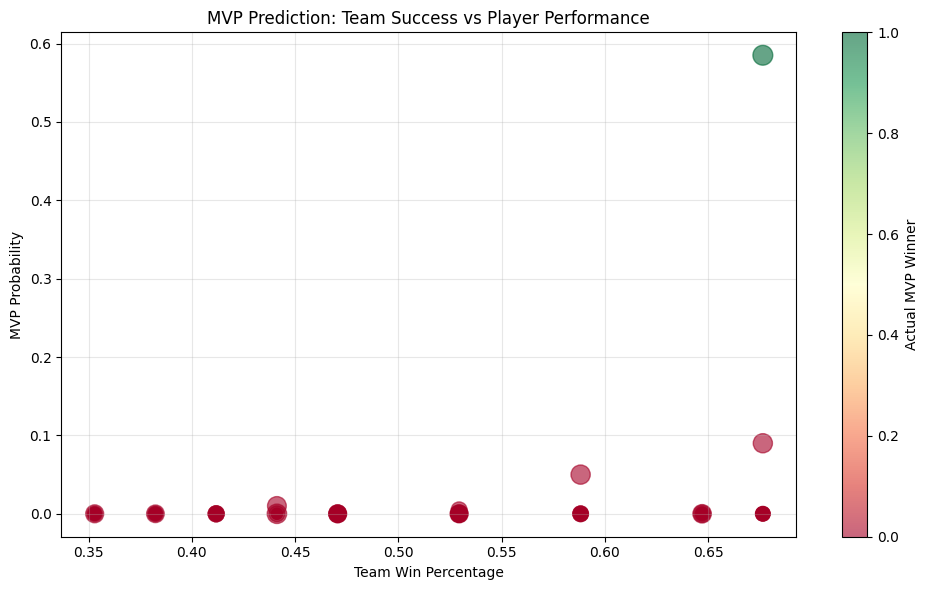


💡 Insight: MVP candidates typically come from winning teams (playoff contenders)


In [24]:
# ===============================================================
# 🏀 MVP PREDICTION — MODEL & EVALUATION
# ===============================================================

# ===============================================================
# 1️⃣ Load prepared dataset
# ===============================================================
player_df = pd.read_csv("data_models/awards_dataset.csv")

# ===============================================================
# 2️⃣ Choose target year
# ===============================================================
target_year = 10
train_data = player_df[player_df["year"] < target_year]
test_data = player_df[player_df["year"] == target_year]

print(f"Treino: {train_data.shape} | Teste ({target_year}): {test_data.shape}")

# ===============================================================
# 3️⃣ Define features and target for MVP
# ===============================================================
features = [
    'ppg', 'rpg', 'apg', 'spg', 'bpg', 'mpg',
    'fg_pct', 'efficiency', 'gs_pct', 'win_pct', 'GP', 'GS',
    'made_playoffs', 'conf_rank', 
    'ppg_vs_avg', 'rpg_vs_avg', 'apg_vs_avg', 'efficiency_vs_avg'
]
target = 'won_most_valuable_player'

X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

print(f"\nMVP winners in training: {y_train.sum()}")
print(f"MVP winners in test: {y_test.sum()}")
print(f"Class balance: {y_train.sum()}/{len(y_train)} = {y_train.sum()/len(y_train)*100:.2f}%")

# ===============================================================
# 4️⃣ Train Random Forest model
# ===============================================================
model_mvp = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    class_weight='balanced'
)
model_mvp.fit(X_train, y_train)

# ===============================================================
# 5️⃣ Predictions
# ===============================================================
test_data = test_data.copy()
test_data.loc[:, 'mvp_proba'] = model_mvp.predict_proba(X_test)[:, 1]

# Rank players by probability
test_data.loc[:, 'mvp_rank'] = test_data['mvp_proba'].rank(ascending=False, method='first')

# ===============================================================
# 6️⃣ Evaluation
# ===============================================================
# Initialize variables
winner_rank = None
winner_proba = None
actual_winner_id = None

# For awards, what matters is: Is the winner in our top predictions?
actual_winner_id_array = test_data[test_data[target] == 1]['playerID'].values
if len(actual_winner_id_array) > 0:
    actual_winner_id = actual_winner_id_array[0]
    winner_rank = test_data[test_data['playerID'] == actual_winner_id]['mvp_rank'].values[0]
    winner_proba = test_data[test_data['playerID'] == actual_winner_id]['mvp_proba'].values[0]
    
    print(f"\n📊 MVP Ranking Evaluation for year {target_year}:")
    print(f"Actual winner rank: {int(winner_rank)} out of {len(test_data)}")
    print(f"Actual winner probability: {winner_proba:.3f}")
    print(f"Top-1 prediction: {'✓ CORRECT' if winner_rank == 1 else '✗ INCORRECT'}")
    print(f"Top-3 prediction: {'✓ CORRECT' if winner_rank <= 3 else '✗ INCORRECT'}")
    print(f"Top-5 prediction: {'✓ CORRECT' if winner_rank <= 5 else '✗ INCORRECT'}")
    print(f"Top-10 prediction: {'✓ CORRECT' if winner_rank <= 10 else '✗ INCORRECT'}")
    
    # Mean Reciprocal Rank (standard metric for ranking problems)
    mrr = 1.0 / winner_rank
    print(f"Mean Reciprocal Rank: {mrr:.4f}")
    
    # Spearman correlation between predicted probabilities and actual winner
    # Create binary actual ranking (1 for winner, 0 for others)
    test_data['actual_winner'] = (test_data['playerID'] == actual_winner_id).astype(int)
    spearman_corr, spearman_p = spearmanr(-test_data['mvp_proba'], test_data['mvp_rank'])
    print(f"Spearman Rank Correlation: {spearman_corr:.4f} (p={spearman_p:.4f})")
else:
    print("\nNo MVP winner in test set")

# ===============================================================
# 6b️⃣ Baseline Comparison
# ===============================================================
print("\n📌 Baseline Comparison:")
print("Baseline strategy: Rank by efficiency (simple heuristic)")
test_data['baseline_rank'] = test_data['efficiency'].rank(ascending=False, method='first')

if actual_winner_id is not None:
    baseline_winner_rank = test_data[test_data['playerID'] == actual_winner_id]['baseline_rank'].values[0]
    print(f"  Baseline model ranks winner at: #{int(baseline_winner_rank)}")
    print(f"  Our model ranks winner at: #{int(winner_rank)}")
    print(f"  Improvement: {int(baseline_winner_rank - winner_rank)} positions {'better' if winner_rank < baseline_winner_rank else 'worse'}")


# ===============================================================
# 7️⃣ Top MVP candidates
# ===============================================================
print("\n🏆 Top 10 MVP candidates:")
top_mvp = test_data[[
    'playerID', 'tmID', 'ppg', 'rpg', 'apg', 'efficiency',
    'win_pct', 'made_playoffs', 'conf_rank',
    'mvp_proba', 'mvp_rank', 'won_most_valuable_player'
]].sort_values('mvp_proba', ascending=False).head(10)
print(top_mvp[['playerID', 'tmID', 'ppg', 'win_pct', 'made_playoffs', 'mvp_proba', 'mvp_rank', 'won_most_valuable_player']])

# ===============================================================
# 8️⃣ Feature Importance
# ===============================================================
importance = pd.DataFrame({
    'Feature': features,
    'Importance': model_mvp.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(data=importance, x='Importance', y='Feature', hue='Feature', palette='viridis', legend=False)
plt.title('MVP Feature Importance - Random Forest')
plt.tight_layout()
plt.show()

print("\n💡 Top 5 Most Important Features:")
print(importance.head())

# ===============================================================
# 8b️⃣ Probability Distribution Analysis
# ===============================================================
plt.figure(figsize=(10, 5))

# Left plot: Distribution of predicted probabilities
plt.subplot(1, 2, 1)
plt.hist(test_data['mvp_proba'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
if winner_proba is not None:
    plt.axvline(winner_proba, color='red', linestyle='--', linewidth=2, label=f'Actual Winner ({winner_proba:.3f})')
plt.xlabel('Predicted MVP Probability')
plt.ylabel('Number of Players')
plt.title('Distribution of MVP Probabilities')
plt.legend()
plt.grid(alpha=0.3)

# Right plot: Top candidates probability comparison
plt.subplot(1, 2, 2)
top_5 = test_data.nsmallest(5, 'mvp_rank')
colors = ['red' if pid == actual_winner_id else 'teal' for pid in top_5['playerID']]
plt.barh(range(len(top_5)), top_5['mvp_proba'], color=colors)
plt.yticks(range(len(top_5)), [f"#{int(r)}: {pid}" for r, pid in zip(top_5['mvp_rank'], top_5['playerID'])])
plt.xlabel('Predicted Probability')
plt.title('Top 5 MVP Candidates')
plt.grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.show()


# ===============================================================
# 9️⃣ Save predictions
# ===============================================================
test_data.to_csv("data_models/predictions_mvp.csv", index=False)
print("\n✅ Results saved to: data_models/predictions_mvp.csv")

# ===============================================================
# 🔟 Analysis: Team Success vs MVP Probability
# ===============================================================
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    test_data['win_pct'], 
    test_data['mvp_proba'],
    c=test_data['won_most_valuable_player'],
    s=test_data['ppg']*10,
    alpha=0.6,
    cmap='RdYlGn'
)
plt.xlabel('Team Win Percentage')
plt.ylabel('MVP Probability')
plt.title('MVP Prediction: Team Success vs Player Performance')
plt.colorbar(scatter, label='Actual MVP Winner')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\n💡 Insight: MVP candidates typically come from winning teams (playoff contenders)")

DPOY winners in training: 9
DPOY winners in test: 1
Class balance: 9/1458 = 0.62%

📊 DPOY Ranking Evaluation for year 10:
Actual winner rank: 1 out of 145
Actual winner probability: 0.240
Top-1 prediction: ✓ CORRECT
Top-3 prediction: ✓ CORRECT
Top-5 prediction: ✓ CORRECT
Mean Reciprocal Rank: 1.0000

🛡️ Top 10 DPOY candidates:
        playerID tmID       spg       bpg   win_pct  dpoy_proba  dpoy_rank  \
241   catchta01w  IND  2.911765  0.529412  0.647059    0.239672        1.0   
1362  tauradi01w  PHO  1.161290  1.387097  0.676471    0.049645        2.0   
1596  youngso01w  SAS  1.333333  0.484848  0.441176    0.049151        3.0   
26    anosini01w  MIN  2.700000  0.933333  0.411765    0.040000        4.0   
1054  parkeca01w  LAS  0.600000  2.120000  0.529412    0.039952        5.0   
630   jacksla01w  SEA  1.461538  1.730769  0.588235    0.039924        6.0   
575   hoffmeb01w  IND  1.676471  0.352941  0.647059    0.039751        7.0   
1099  pondeca01w  PHO  0.911765  0.352941  0.67

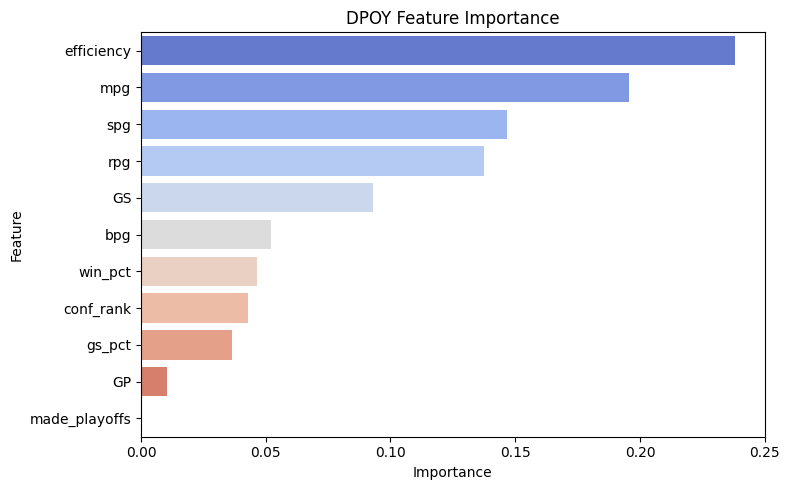


💡 Top 5 Most Important Features:
      Feature  Importance
4  efficiency    0.238133
3         mpg    0.195732
0         spg    0.146764
2         rpg    0.137525
8          GS    0.093045

✅ Results saved to: data_models/predictions_dpoy.csv


In [25]:
# ===============================================================
# 🛡️ DEFENSIVE PLAYER OF THE YEAR — MODEL & EVALUATION
# ===============================================================

# ===============================================================
# 1️⃣ Load data (already prepared)
# ===============================================================
target_year = 10
train_data = player_df[player_df["year"] < target_year]
test_data = player_df[player_df["year"] == target_year]

# ===============================================================
# 2️⃣ Features focused on defense
# ===============================================================
features_dpoy = [
    'spg', 'bpg', 'rpg', 'mpg', 'efficiency',
    'gs_pct', 'win_pct', 'GP', 'GS',
    'made_playoffs', 'conf_rank'
]
target = 'won_defensive_player_of_the_year'

X_train = train_data[features_dpoy]
y_train = train_data[target]
X_test = test_data[features_dpoy]
y_test = test_data[target]

print(f"DPOY winners in training: {y_train.sum()}")
print(f"DPOY winners in test: {y_test.sum()}")
print(f"Class balance: {y_train.sum()}/{len(y_train)} = {y_train.sum()/len(y_train)*100:.2f}%")

# ===============================================================
# 3️⃣ Train model
# ===============================================================
model_dpoy = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    class_weight='balanced'
)
model_dpoy.fit(X_train, y_train)

# ===============================================================
# 4️⃣ Predictions
# ===============================================================
test_data = test_data.copy()
test_data.loc[:, 'dpoy_proba'] = model_dpoy.predict_proba(X_test)[:, 1]
test_data.loc[:, 'dpoy_rank'] = test_data['dpoy_proba'].rank(ascending=False, method='first')

# ===============================================================
# 5️⃣ Evaluation
# ===============================================================
actual_winner_id_array = test_data[test_data[target] == 1]['playerID'].values
if len(actual_winner_id_array) > 0:
    actual_winner_id = actual_winner_id_array[0]
    winner_rank = test_data[test_data['playerID'] == actual_winner_id]['dpoy_rank'].values[0]
    winner_proba = test_data[test_data['playerID'] == actual_winner_id]['dpoy_proba'].values[0]
    
    print(f"\n📊 DPOY Ranking Evaluation for year {target_year}:")
    print(f"Actual winner rank: {int(winner_rank)} out of {len(test_data)}")
    print(f"Actual winner probability: {winner_proba:.3f}")
    print(f"Top-1 prediction: {'✓ CORRECT' if winner_rank == 1 else '✗ INCORRECT'}")
    print(f"Top-3 prediction: {'✓ CORRECT' if winner_rank <= 3 else '✗ INCORRECT'}")
    print(f"Top-5 prediction: {'✓ CORRECT' if winner_rank <= 5 else '✗ INCORRECT'}")
    
    mrr = 1.0 / winner_rank
    print(f"Mean Reciprocal Rank: {mrr:.4f}")
else:
    print("\nNo DPOY winner in test set")

# ===============================================================
# 6️⃣ Top DPOY candidates
# ===============================================================
print("\n🛡️ Top 10 DPOY candidates:")
top_dpoy = test_data[[
    'playerID', 'tmID', 'spg', 'bpg', 'rpg',
    'win_pct', 'made_playoffs',
    'dpoy_proba', 'dpoy_rank', 'won_defensive_player_of_the_year'
]].sort_values('dpoy_proba', ascending=False).head(10)
print(top_dpoy[['playerID', 'tmID', 'spg', 'bpg', 'win_pct', 'dpoy_proba', 'dpoy_rank', 'won_defensive_player_of_the_year']])

# ===============================================================
# 7️⃣ Feature Importance
# ===============================================================
importance = pd.DataFrame({
    'Feature': features_dpoy,
    'Importance': model_dpoy.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(data=importance, x='Importance', y='Feature', hue='Feature', palette='coolwarm', legend=False)
plt.title('DPOY Feature Importance')
plt.tight_layout()
plt.show()

print("\n💡 Top 5 Most Important Features:")
print(importance.head())

# ===============================================================
# 8️⃣ Save predictions
# ===============================================================
test_data.to_csv("data_models/predictions_dpoy.csv", index=False)
print("\n✅ Results saved to: data_models/predictions_dpoy.csv")

Rookie training data: (441, 69)
Rookie test data: (20, 69)

ROY winners in training: 9
ROY winners in test: 1
Class balance: 9/441 = 2.04%

📊 ROY Ranking Evaluation for year 10:
Actual winner rank: 2 out of 20
Actual winner probability: 0.005
Top-1 prediction: ✗ INCORRECT
Top-3 prediction: ✓ CORRECT
Top-5 prediction: ✓ CORRECT
Mean Reciprocal Rank: 0.5000

🌟 Top 10 Rookie of the Year candidates:
       playerID tmID        ppg   win_pct  roy_proba  roy_rank  \
130  bonnede01w  PHO  11.205882  0.676471   0.014873       1.0   
883  mccouan01w  ATL  12.794118  0.529412   0.005000       2.0   
264  colemma01w  WAS   6.107143  0.470588   0.000000       4.0   
106  blackch01w  CON   2.939394  0.470588   0.000000       3.0   
436  frazeme01w  SAS   5.000000  0.441176   0.000000       5.0   
590  holliqu01w  MIN   4.823529  0.411765   0.000000       6.0   
648  jekaban01w  CON   9.444444  0.470588   0.000000       8.0   
647  januabr01w  IND   6.878788  0.647059   0.000000       7.0   
762  le

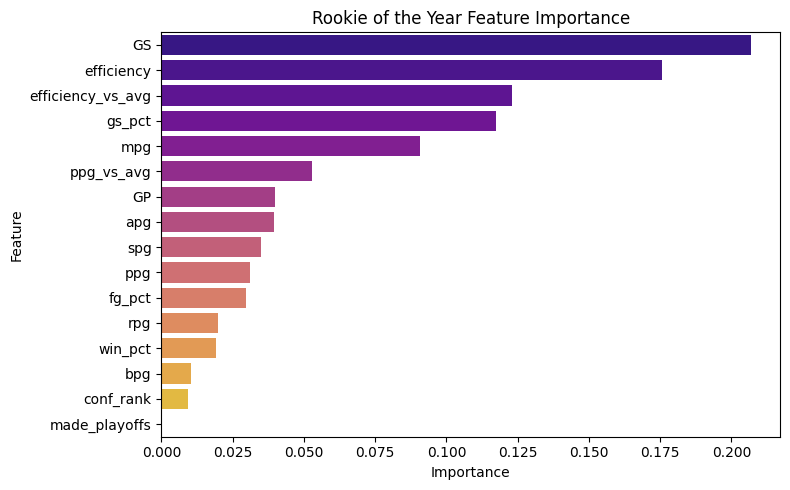


💡 Top 5 Most Important Features:
              Feature  Importance
10                 GS    0.206694
7          efficiency    0.175499
15  efficiency_vs_avg    0.123135
8              gs_pct    0.117260
5                 mpg    0.090682

✅ Results saved to: data_models/predictions_roy.csv


In [26]:
# ===============================================================
# 🌟 ROOKIE OF THE YEAR — MODEL & EVALUATION
# ===============================================================

# ===============================================================
# 1️⃣ Filter only rookies
# ===============================================================
target_year = 10
train_rookies = player_df[(player_df["year"] < target_year) & (player_df["is_rookie"] == 1)]
test_rookies = player_df[(player_df["year"] == target_year) & (player_df["is_rookie"] == 1)]

print(f"Rookie training data: {train_rookies.shape}")
print(f"Rookie test data: {test_rookies.shape}")

# ===============================================================
# 2️⃣ Features for rookies
# ===============================================================
features_roy = [
    'ppg', 'rpg', 'apg', 'spg', 'bpg', 'mpg',
    'fg_pct', 'efficiency', 'gs_pct', 'GP', 'GS',
    'win_pct', 'made_playoffs', 'conf_rank',
    'ppg_vs_avg', 'efficiency_vs_avg'
]
target = 'won_rookie_of_the_year'

X_train = train_rookies[features_roy]
y_train = train_rookies[target]
X_test = test_rookies[features_roy]
y_test = test_rookies[target]

print(f"\nROY winners in training: {y_train.sum()}")
print(f"ROY winners in test: {y_test.sum()}")
print(f"Class balance: {y_train.sum()}/{len(y_train)} = {y_train.sum()/len(y_train)*100:.2f}%")

# ===============================================================
# 3️⃣ Train model
# ===============================================================
model_roy = RandomForestClassifier(
    n_estimators=200,
    max_depth=8,
    random_state=42,
    class_weight='balanced'
)
model_roy.fit(X_train, y_train)

# ===============================================================
# 4️⃣ Predictions
# ===============================================================
test_rookies = test_rookies.copy()
test_rookies.loc[:, 'roy_proba'] = model_roy.predict_proba(X_test)[:, 1]
test_rookies.loc[:, 'roy_rank'] = test_rookies['roy_proba'].rank(ascending=False, method='first')

# ===============================================================
# 5️⃣ Evaluation
# ===============================================================
# Initialize variables
winner_rank = None
winner_proba = None

actual_winner_id_array = test_rookies[test_rookies[target] == 1]['playerID'].values
if len(actual_winner_id_array) > 0:
    actual_winner_id = actual_winner_id_array[0]
    winner_rank = test_rookies[test_rookies['playerID'] == actual_winner_id]['roy_rank'].values[0]
    winner_proba = test_rookies[test_rookies['playerID'] == actual_winner_id]['roy_proba'].values[0]
    
    print(f"\n📊 ROY Ranking Evaluation for year {target_year}:")
    print(f"Actual winner rank: {int(winner_rank)} out of {len(test_rookies)}")
    print(f"Actual winner probability: {winner_proba:.3f}")
    print(f"Top-1 prediction: {'✓ CORRECT' if winner_rank == 1 else '✗ INCORRECT'}")
    print(f"Top-3 prediction: {'✓ CORRECT' if winner_rank <= 3 else '✗ INCORRECT'}")
    print(f"Top-5 prediction: {'✓ CORRECT' if winner_rank <= 5 else '✗ INCORRECT'}")
    
    mrr = 1.0 / winner_rank
    print(f"Mean Reciprocal Rank: {mrr:.4f}")
else:
    print("\nNo ROY winner in test set")

# ===============================================================
# 6️⃣ Top ROY candidates
# ===============================================================
print("\n🌟 Top 10 Rookie of the Year candidates:")
top_roy = test_rookies[[
    'playerID', 'tmID', 'ppg', 'rpg', 'apg', 'efficiency',
    'win_pct', 'made_playoffs',
    'roy_proba', 'roy_rank', 'won_rookie_of_the_year'
]].sort_values('roy_proba', ascending=False).head(10)
print(top_roy[['playerID', 'tmID', 'ppg', 'win_pct', 'roy_proba', 'roy_rank', 'won_rookie_of_the_year']])

# ===============================================================
# 7️⃣ Feature Importance
# ===============================================================
importance = pd.DataFrame({
    'Feature': features_roy,
    'Importance': model_roy.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(data=importance, x='Importance', y='Feature', hue='Feature', palette='plasma', legend=False)
plt.title('Rookie of the Year Feature Importance')
plt.tight_layout()
plt.show()

print("\n💡 Top 5 Most Important Features:")
print(importance.head())

# ===============================================================
# 8️⃣ Save predictions
# ===============================================================
test_rookies.to_csv("data_models/predictions_roy.csv", index=False)
print("\n✅ Results saved to: data_models/predictions_roy.csv")

In [27]:
# ===============================================================
# 📋 SUMMARY OF ALL AWARD PREDICTIONS
# ===============================================================

print("="*70)
print(f"FINAL AWARD PREDICTIONS FOR YEAR {target_year}")
print("="*70)

mvp_pred = pd.read_csv("data_models/predictions_mvp.csv")
dpoy_pred = pd.read_csv("data_models/predictions_dpoy.csv")
roy_pred = pd.read_csv("data_models/predictions_roy.csv")

mvp_winner = mvp_pred.nlargest(1, 'mvp_proba')
dpoy_winner = dpoy_pred.nlargest(1, 'dpoy_proba')
roy_winner = roy_pred.nlargest(1, 'roy_proba')

mvp_actual = mvp_pred[mvp_pred['won_most_valuable_player'] == 1]
dpoy_actual = dpoy_pred[dpoy_pred['won_defensive_player_of_the_year'] == 1]
roy_actual = roy_pred[roy_pred['won_rookie_of_the_year'] == 1]

print("\n🏆 MOST VALUABLE PLAYER:")
print(f"  Predicted: {mvp_winner['playerID'].values[0]}")
print(f"  Team: {mvp_winner['tmID'].values[0]}")
print(f"  PPG: {mvp_winner['ppg'].values[0]:.1f}")
print(f"  RPG: {mvp_winner['rpg'].values[0]:.1f}")
print(f"  APG: {mvp_winner['apg'].values[0]:.1f}")
print(f"  Confidence: {mvp_winner['mvp_proba'].values[0]:.1%}")
if len(mvp_actual) > 0:
    is_correct = mvp_winner['playerID'].values[0] == mvp_actual['playerID'].values[0]
    actual_rank = int(mvp_actual['mvp_rank'].values[0])
    print(f"  Prediction: {'✓ CORRECT' if is_correct else f'✗ INCORRECT (actual winner ranked #{actual_rank})'}")
    print(f"  Actual winner: {mvp_actual['playerID'].values[0]}")

print("\n🛡️ DEFENSIVE PLAYER OF THE YEAR:")
print(f"  Predicted: {dpoy_winner['playerID'].values[0]}")
print(f"  Team: {dpoy_winner['tmID'].values[0]}")
print(f"  SPG: {dpoy_winner['spg'].values[0]:.1f}")
print(f"  BPG: {dpoy_winner['bpg'].values[0]:.1f}")
print(f"  RPG: {dpoy_winner['rpg'].values[0]:.1f}")
print(f"  Confidence: {dpoy_winner['dpoy_proba'].values[0]:.1%}")
if len(dpoy_actual) > 0:
    is_correct = dpoy_winner['playerID'].values[0] == dpoy_actual['playerID'].values[0]
    actual_rank = int(dpoy_actual['dpoy_rank'].values[0])
    print(f"  Prediction: {'✓ CORRECT' if is_correct else f'✗ INCORRECT (actual winner ranked #{actual_rank})'}")
    print(f"  Actual winner: {dpoy_actual['playerID'].values[0]}")

print("\n🌟 ROOKIE OF THE YEAR:")
print(f"  Predicted: {roy_winner['playerID'].values[0]}")
print(f"  Team: {roy_winner['tmID'].values[0]}")
print(f"  PPG: {roy_winner['ppg'].values[0]:.1f}")
print(f"  RPG: {roy_winner['rpg'].values[0]:.1f}")
print(f"  APG: {roy_winner['apg'].values[0]:.1f}")
print(f"  Confidence: {roy_winner['roy_proba'].values[0]:.1%}")
if len(roy_actual) > 0:
    is_correct = roy_winner['playerID'].values[0] == roy_actual['playerID'].values[0]
    actual_rank = int(roy_actual['roy_rank'].values[0])
    print(f"  Prediction: {'✓ CORRECT' if is_correct else f'✗ INCORRECT (actual winner ranked #{actual_rank})'}")
    print(f"  Actual winner: {roy_actual['playerID'].values[0]}")

correct = 0
total = 0
if len(mvp_actual) > 0:
    correct += (mvp_winner['playerID'].values[0] == mvp_actual['playerID'].values[0])
    total += 1
if len(dpoy_actual) > 0:
    correct += (dpoy_winner['playerID'].values[0] == dpoy_actual['playerID'].values[0])
    total += 1
if len(roy_actual) > 0:
    correct += (roy_winner['playerID'].values[0] == roy_actual['playerID'].values[0])
    total += 1

print("\n" + "="*70)
print(f"Overall Top-1 Accuracy: {correct}/{total} = {correct/total*100:.1f}%" if total > 0 else "No winners in test set")
print("="*70)
print("✅ All predictions complete!")

# ===============================================================
# 🎯 FINAL INSIGHT: Awards and Team Success
# ===============================================================
print("\n" + "="*70)
print("KEY INSIGHTS FROM THE BASKETBALL CONTEXT:")
print("="*70)

if len(mvp_actual) > 0:
    mvp_team_wins = mvp_actual['win_pct'].values[0]
    mvp_playoffs = mvp_actual['made_playoffs'].values[0]
    print(f"\n🏆 MVP Winner's Team: {mvp_team_wins:.1%} win rate, {'made playoffs' if mvp_playoffs else 'missed playoffs'}")

if len(dpoy_actual) > 0:
    dpoy_team_wins = dpoy_actual['win_pct'].values[0]
    dpoy_playoffs = dpoy_actual['made_playoffs'].values[0]
    print(f"🛡️ DPOY Winner's Team: {dpoy_team_wins:.1%} win rate, {'made playoffs' if dpoy_playoffs else 'missed playoffs'}")

if len(roy_actual) > 0:
    roy_team_wins = roy_actual['win_pct'].values[0]
    roy_playoffs = roy_actual['made_playoffs'].values[0]
    print(f"🌟 ROY Winner's Team: {roy_team_wins:.1%} win rate, {'made playoffs' if roy_playoffs else 'missed playoffs'}")

print("\n💡 As described in the project: teams with more wins qualify for playoffs.")
print("   Award winners are often from successful teams that make the playoffs.")
print("="*70)

# ===============================================================
# 🎯 COMPREHENSIVE MODEL EVALUATION
# ===============================================================
print("\n" + "="*70)
print("COMPREHENSIVE MODEL EVALUATION METRICS:")
print("="*70)

# Collect all predictions
all_predictions = []
all_actuals = []
all_models = []

# MVP metrics
if len(mvp_actual) > 0:
    mvp_predicted_rank = int(mvp_actual['mvp_rank'].values[0])
    all_predictions.append(mvp_predicted_rank)
    all_actuals.append(1)  # Actual winner is always rank 1
    all_models.append('MVP')
    
# DPOY metrics  
if len(dpoy_actual) > 0:
    dpoy_predicted_rank = int(dpoy_actual['dpoy_rank'].values[0])
    all_predictions.append(dpoy_predicted_rank)
    all_actuals.append(1)
    all_models.append('DPOY')
    
# ROY metrics
if len(roy_actual) > 0:
    roy_predicted_rank = int(roy_actual['roy_rank'].values[0])
    all_predictions.append(roy_predicted_rank)
    all_actuals.append(1)
    all_models.append('ROY')

# Calculate aggregate metrics
if len(all_predictions) > 0:
    print("\n📊 Ranking Performance Metrics:")
    print(f"  Average Winner Rank: {np.mean(all_predictions):.2f}")
    print(f"  Median Winner Rank: {np.median(all_predictions):.1f}")
    print(f"  Best Rank: {np.min(all_predictions)}")
    print(f"  Worst Rank: {np.max(all_predictions)}")
    print(f"  Average MRR: {np.mean([1.0/r for r in all_predictions]):.4f}")
    
    print("\n🎯 Success Rate by Top-K:")
    for k in [1, 3, 5, 10]:
        success_rate = np.mean([r <= k for r in all_predictions]) * 100
        print(f"  Top-{k:2d}: {success_rate:.1f}% ({int(success_rate * len(all_predictions) / 100)}/{len(all_predictions)} awards)")
    
    print("\n📈 Per-Award Performance:")
    for model, pred_rank in zip(all_models, all_predictions):
        mrr = 1.0 / pred_rank
        status = "✓" if pred_rank == 1 else "✗"
        print(f"  {model:4s}: Rank #{pred_rank:2d} | MRR={mrr:.4f} | {status}")

print("\n" + "="*70)


FINAL AWARD PREDICTIONS FOR YEAR 10

🏆 MOST VALUABLE PLAYER:
  Predicted: tauradi01w
  Team: PHO
  PPG: 20.4
  RPG: 5.7
  APG: 3.5
  Confidence: 58.5%
  Prediction: ✓ CORRECT
  Actual winner: tauradi01w

🛡️ DEFENSIVE PLAYER OF THE YEAR:
  Predicted: catchta01w
  Team: IND
  SPG: 2.9
  BPG: 0.5
  RPG: 7.2
  Confidence: 24.0%
  Prediction: ✓ CORRECT
  Actual winner: catchta01w

🌟 ROOKIE OF THE YEAR:
  Predicted: bonnede01w
  Team: PHO
  PPG: 11.2
  RPG: 5.8
  APG: 0.4
  Confidence: 1.5%
  Prediction: ✗ INCORRECT (actual winner ranked #2)
  Actual winner: mccouan01w

Overall Top-1 Accuracy: 2/3 = 66.7%
✅ All predictions complete!

KEY INSIGHTS FROM THE BASKETBALL CONTEXT:

🏆 MVP Winner's Team: 67.6% win rate, made playoffs
🛡️ DPOY Winner's Team: 64.7% win rate, made playoffs
🌟 ROY Winner's Team: 52.9% win rate, made playoffs

💡 As described in the project: teams with more wins qualify for playoffs.
   Award winners are often from successful teams that make the playoffs.

COMPREHENSIVE MOD

## 📊 Advanced Visualizations & Comprehensive Analysis

This section provides deeper insights through advanced visualizations that go beyond basic feature importance.

/tmp/ipykernel_2512/3447463228.py:66: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/dee/up/ac-data-mining-project/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


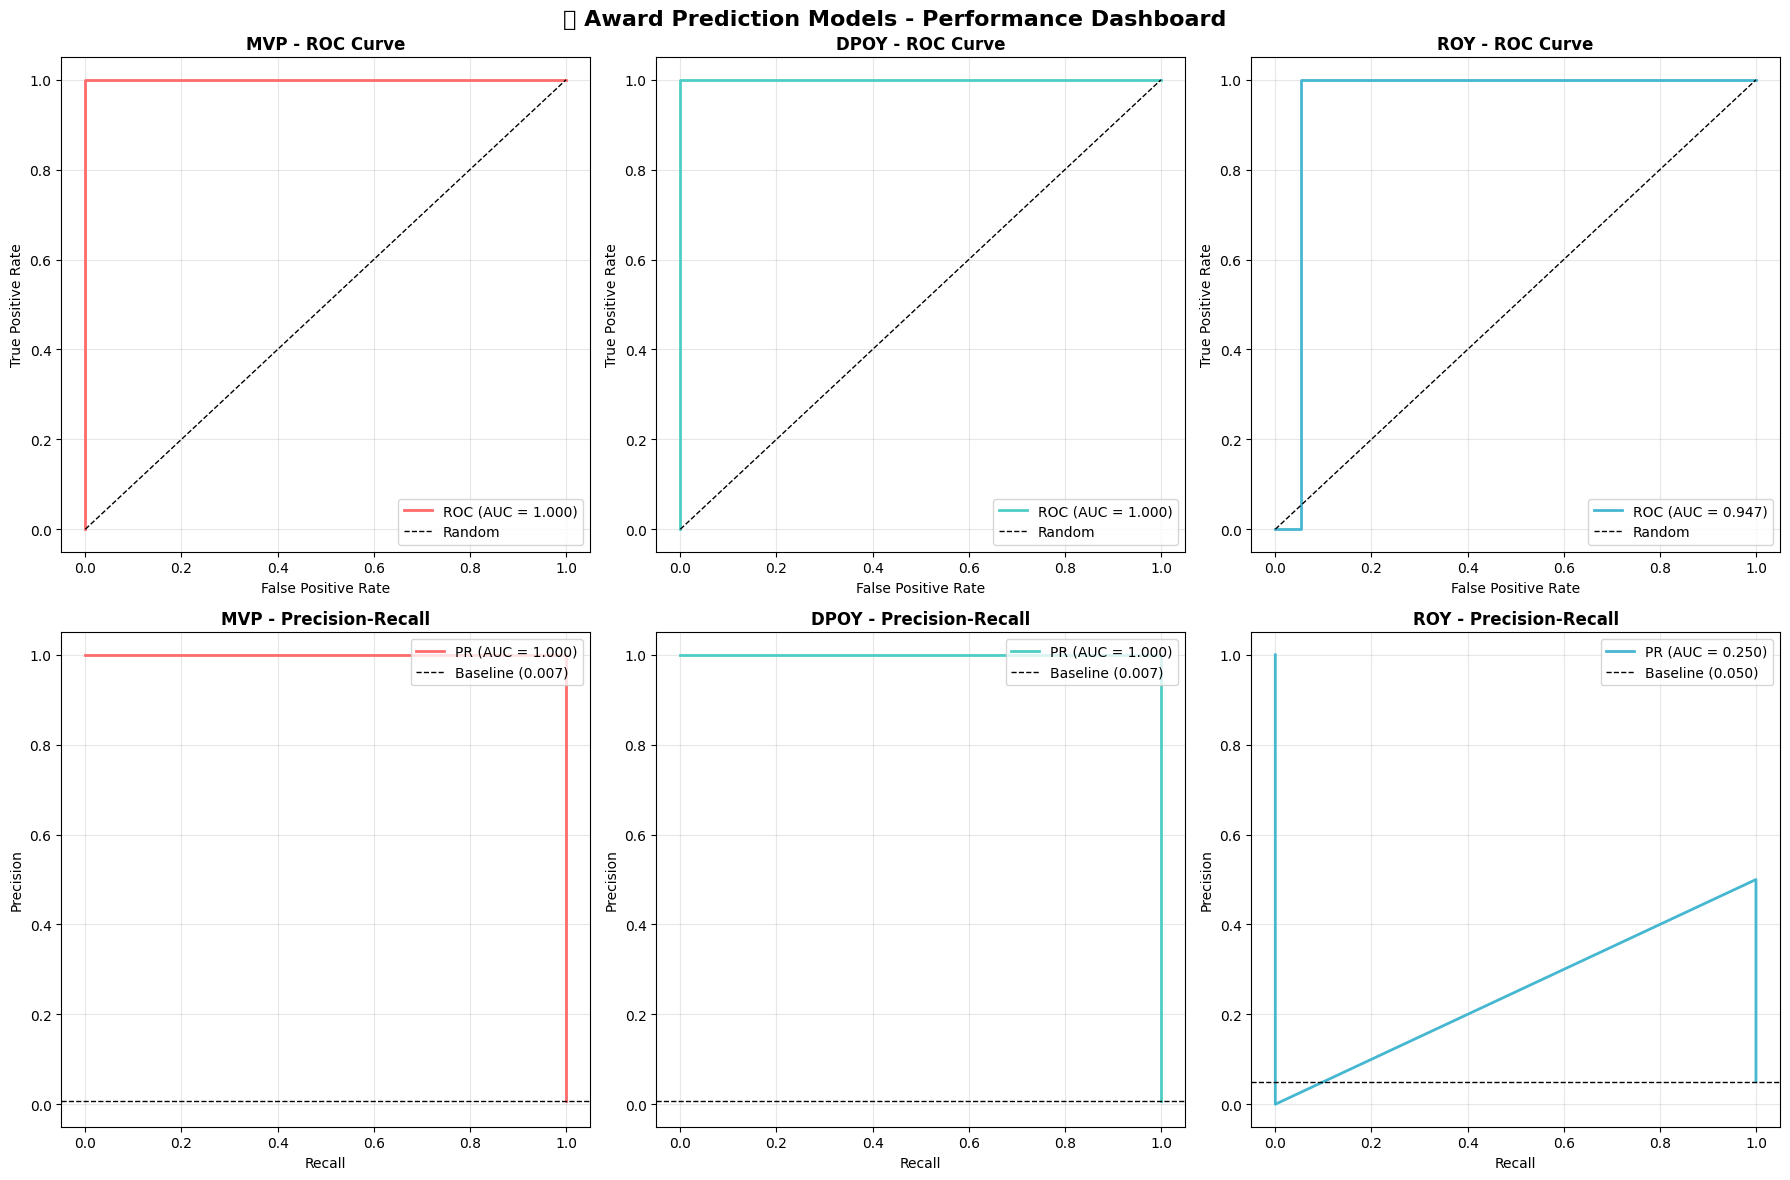


📊 Model Performance Summary:

MVP:
  ROC-AUC: 1.0000
  PR-AUC:  1.0000
  Class Imbalance: 1/145 (0.69%)

DPOY:
  ROC-AUC: 1.0000
  PR-AUC:  1.0000
  Class Imbalance: 1/145 (0.69%)

ROY:
  ROC-AUC: 0.9474
  PR-AUC:  0.2500
  Class Imbalance: 1/20 (5.00%)


In [28]:
# ===============================================================
# 📊 VISUALIZATION 1: Model Performance Comparison Dashboard
# ===============================================================
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('🎯 Award Prediction Models - Performance Dashboard', fontsize=16, fontweight='bold')

# Load all predictions
mvp_pred = pd.read_csv("data_models/predictions_mvp.csv")
dpoy_pred = pd.read_csv("data_models/predictions_dpoy.csv")
roy_pred = pd.read_csv("data_models/predictions_roy.csv")

all_predictions = [mvp_pred, dpoy_pred, roy_pred]
all_models = ['MVP', 'DPOY', 'ROY']
all_actuals = ['won_most_valuable_player', 'won_defensive_player_of_the_year', 'won_rookie_of_the_year']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

# Row 1: ROC Curves
for idx, (pred_df, model_name, target, color) in enumerate(zip(all_predictions, all_models, all_actuals, colors)):
    ax = axes[0, idx]
    
    # Get predictions
    y_true = pred_df[target].values
    y_proba = pred_df[f'{model_name.lower()}_proba'].values
    
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)
    
    # Plot
    ax.plot(fpr, tpr, color=color, lw=2, label=f'ROC (AUC = {roc_auc:.3f})')
    ax.plot([0, 1], [0, 1], 'k--', lw=1, label='Random')
    ax.set_xlabel('False Positive Rate', fontsize=10)
    ax.set_ylabel('True Positive Rate', fontsize=10)
    ax.set_title(f'{model_name} - ROC Curve', fontsize=12, fontweight='bold')
    ax.legend(loc='lower right')
    ax.grid(alpha=0.3)
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])

# Row 2: Precision-Recall Curves
for idx, (pred_df, model_name, target, color) in enumerate(zip(all_predictions, all_models, all_actuals, colors)):
    ax = axes[1, idx]
    
    # Get predictions
    y_true = pred_df[target].values
    y_proba = pred_df[f'{model_name.lower()}_proba'].values
    
    # Calculate precision-recall curve
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    pr_auc = auc(recall, precision)
    
    # Plot
    ax.plot(recall, precision, color=color, lw=2, label=f'PR (AUC = {pr_auc:.3f})')
    baseline = y_true.sum() / len(y_true)
    ax.axhline(baseline, color='k', linestyle='--', lw=1, label=f'Baseline ({baseline:.3f})')
    ax.set_xlabel('Recall', fontsize=10)
    ax.set_ylabel('Precision', fontsize=10)
    ax.set_title(f'{model_name} - Precision-Recall', fontsize=12, fontweight='bold')
    ax.legend(loc='upper right')
    ax.grid(alpha=0.3)
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])

plt.tight_layout()
plt.show()

print("\n📊 Model Performance Summary:")
for pred_df, model_name, target in zip(all_predictions, all_models, all_actuals):
    y_true = pred_df[target].values
    y_proba = pred_df[f'{model_name.lower()}_proba'].values
    
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)
    
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    pr_auc = auc(recall, precision)
    
    print(f"\n{model_name}:")
    print(f"  ROC-AUC: {roc_auc:.4f}")
    print(f"  PR-AUC:  {pr_auc:.4f}")
    print(f"  Class Imbalance: {y_true.sum()}/{len(y_true)} ({y_true.sum()/len(y_true)*100:.2f}%)")

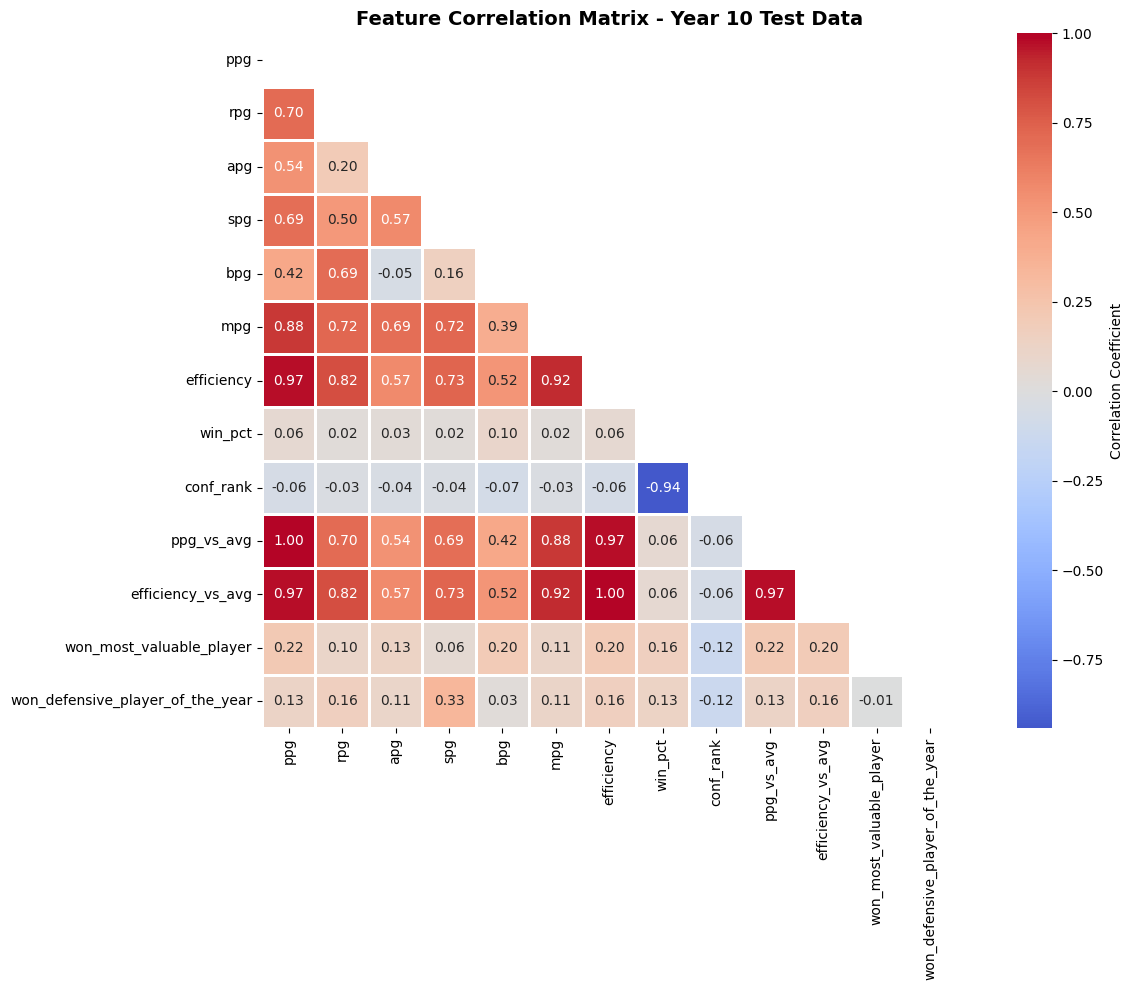


🔍 Strongest Correlations with MVP Award:
ppg_vs_avg           0.217431
ppg                  0.217431
efficiency           0.203203
efficiency_vs_avg    0.203203
bpg                  0.200974
win_pct              0.158891
apg                  0.130632
mpg                  0.110548
Name: won_most_valuable_player, dtype: float64

🔍 Strongest Correlations with DPOY Award:
spg                  0.334985
efficiency           0.164592
efficiency_vs_avg    0.164592
rpg                  0.159587
win_pct              0.132164
ppg                  0.126190
ppg_vs_avg           0.126190
mpg                  0.114433
Name: won_defensive_player_of_the_year, dtype: float64


In [29]:
# ===============================================================
# 📊 VISUALIZATION 2: Feature Correlation Heatmap
# ===============================================================

# Load the dataset
player_df = pd.read_csv("data_models/awards_dataset.csv")
test_year_data = player_df[player_df['year'] == 10]

# Select key features for correlation analysis
key_features = [
    'ppg', 'rpg', 'apg', 'spg', 'bpg', 'mpg',
    'efficiency', 'win_pct', 'conf_rank',
    'ppg_vs_avg', 'efficiency_vs_avg',
    'won_most_valuable_player', 'won_defensive_player_of_the_year'
]

# Calculate correlation matrix
corr_matrix = test_year_data[key_features].corr()

# Create heatmap
plt.figure(figsize=(14, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Mask upper triangle
sns.heatmap(
    corr_matrix, 
    mask=mask,
    annot=True, 
    fmt='.2f', 
    cmap='coolwarm', 
    center=0,
    square=True,
    linewidths=1,
    cbar_kws={'label': 'Correlation Coefficient'}
)
plt.title('Feature Correlation Matrix - Year 10 Test Data', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Identify strongest correlations with awards
print("\n🔍 Strongest Correlations with MVP Award:")
mvp_corr = corr_matrix['won_most_valuable_player'].drop('won_most_valuable_player').sort_values(ascending=False)
print(mvp_corr.head(8))

print("\n🔍 Strongest Correlations with DPOY Award:")
dpoy_corr = corr_matrix['won_defensive_player_of_the_year'].drop('won_defensive_player_of_the_year').sort_values(ascending=False)
print(dpoy_corr.head(8))

/tmp/ipykernel_2512/3729373977.py:114: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/dee/up/ac-data-mining-project/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


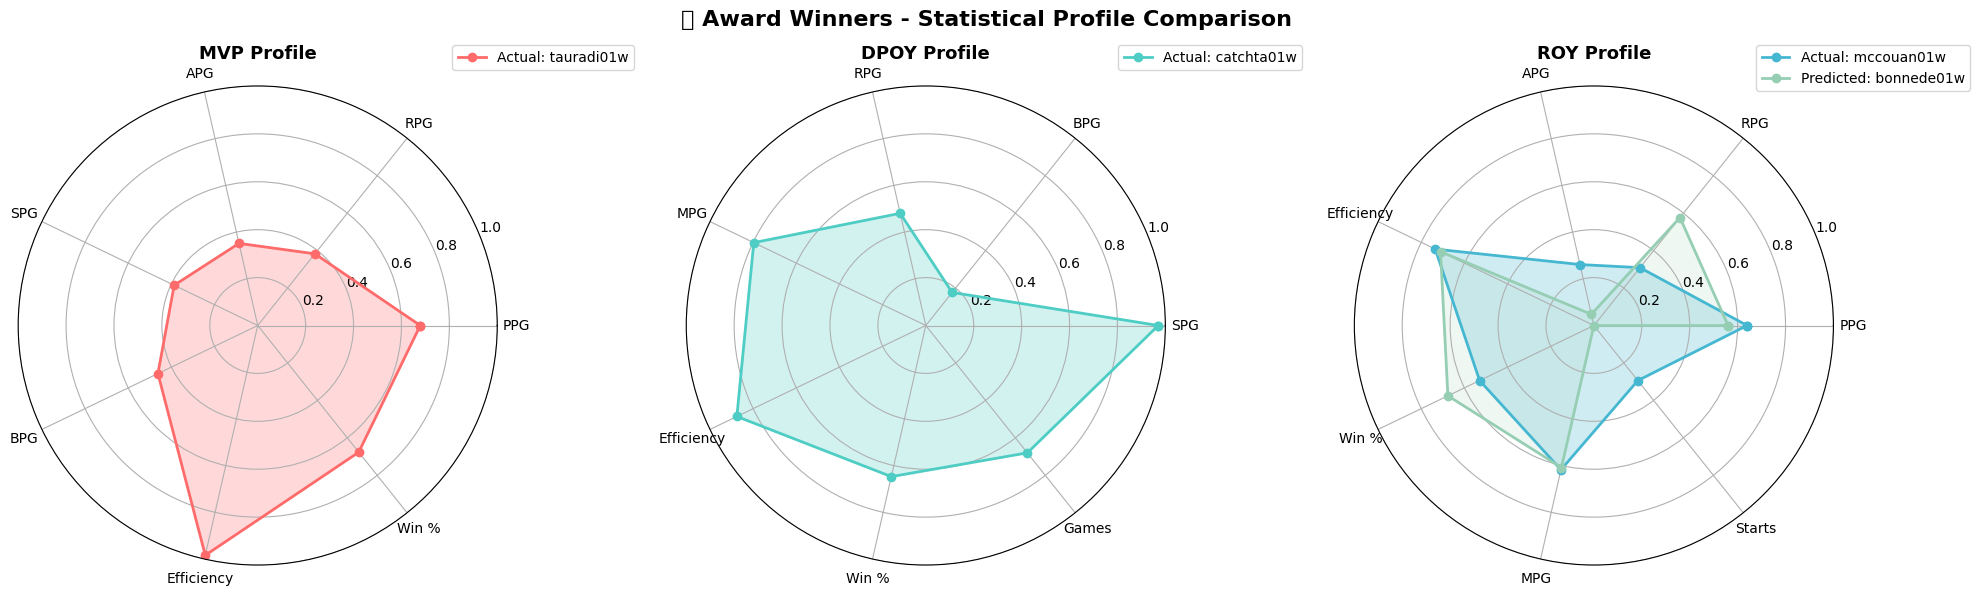


📊 Winner vs Predicted Statistical Comparison:

 MVP:
  Actual:    tauradi01w (PHO) - 20.4 PPG, 67.6% Win Rate
  Predicted: tauradi01w (PHO) - 20.4 PPG, 67.6% Win Rate
  Match: ✓ CORRECT

 DPOY:
  Actual:    catchta01w (IND) - 2.9 SPG, 0.5 BPG
  Predicted: catchta01w (IND) - 2.9 SPG, 0.5 BPG
  Match: ✓ CORRECT

 ROY:
  Actual:    mccouan01w (ATL) - 12.8 PPG, 10 Starts
  Predicted: bonnede01w (PHO) - 11.2 PPG, 0 Starts
  Match: ✗ INCORRECT


In [30]:
# ===============================================================
# 📊 VISUALIZATION 3: Winner Profile Analysis - Radar Charts
# ===============================================================

from math import pi

# Get winners and top candidates
mvp_winner = mvp_pred[mvp_pred['won_most_valuable_player'] == 1].iloc[0]
mvp_predicted = mvp_pred.nsmallest(1, 'mvp_rank').iloc[0]

dpoy_winner = dpoy_pred[dpoy_pred['won_defensive_player_of_the_year'] == 1].iloc[0]
dpoy_predicted = dpoy_pred.nsmallest(1, 'dpoy_rank').iloc[0]

roy_winner = roy_pred[roy_pred['won_rookie_of_the_year'] == 1].iloc[0]
roy_predicted = roy_pred.nsmallest(1, 'roy_rank').iloc[0]

# Create radar charts
fig, axes = plt.subplots(1, 3, figsize=(20, 6), subplot_kw=dict(projection='polar'))
fig.suptitle('🎯 Award Winners - Statistical Profile Comparison', fontsize=16, fontweight='bold')

# MVP Radar Chart
ax = axes[0]
categories = ['PPG', 'RPG', 'APG', 'SPG', 'BPG', 'Efficiency', 'Win %']
values_winner = [
    mvp_winner['ppg']/30, mvp_winner['rpg']/15, mvp_winner['apg']/10,
    mvp_winner['spg']/3, mvp_winner['bpg']/3, mvp_winner['efficiency']/30,
    mvp_winner['win_pct']
]
values_pred = [
    mvp_predicted['ppg']/30, mvp_predicted['rpg']/15, mvp_predicted['apg']/10,
    mvp_predicted['spg']/3, mvp_predicted['bpg']/3, mvp_predicted['efficiency']/30,
    mvp_predicted['win_pct']
]

angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
values_winner += values_winner[:1]
values_pred += values_pred[:1]
angles += angles[:1]

ax.plot(angles, values_winner, 'o-', linewidth=2, label=f'Actual: {mvp_winner["playerID"]}', color='#FF6B6B')
ax.fill(angles, values_winner, alpha=0.25, color='#FF6B6B')
if mvp_winner['playerID'] != mvp_predicted['playerID']:
    ax.plot(angles, values_pred, 'o-', linewidth=2, label=f'Predicted: {mvp_predicted["playerID"]}', color='#FFA07A')
    ax.fill(angles, values_pred, alpha=0.15, color='#FFA07A')
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=10)
ax.set_ylim(0, 1)
ax.set_title('MVP Profile', size=13, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
ax.grid(True)

# DPOY Radar Chart
ax = axes[1]
categories = ['SPG', 'BPG', 'RPG', 'MPG', 'Efficiency', 'Win %', 'Games']
values_winner = [
    dpoy_winner['spg']/3, dpoy_winner['bpg']/3, dpoy_winner['rpg']/15,
    dpoy_winner['mpg']/40, dpoy_winner['efficiency']/30, dpoy_winner['win_pct'],
    dpoy_winner['GP']/50
]
values_pred = [
    dpoy_predicted['spg']/3, dpoy_predicted['bpg']/3, dpoy_predicted['rpg']/15,
    dpoy_predicted['mpg']/40, dpoy_predicted['efficiency']/30, dpoy_predicted['win_pct'],
    dpoy_predicted['GP']/50
]

angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
values_winner += values_winner[:1]
values_pred += values_pred[:1]
angles += angles[:1]

ax.plot(angles, values_winner, 'o-', linewidth=2, label=f'Actual: {dpoy_winner["playerID"]}', color='#4ECDC4')
ax.fill(angles, values_winner, alpha=0.25, color='#4ECDC4')
if dpoy_winner['playerID'] != dpoy_predicted['playerID']:
    ax.plot(angles, values_pred, 'o-', linewidth=2, label=f'Predicted: {dpoy_predicted["playerID"]}', color='#95E1D3')
    ax.fill(angles, values_pred, alpha=0.15, color='#95E1D3')
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=10)
ax.set_ylim(0, 1)
ax.set_title('DPOY Profile', size=13, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
ax.grid(True)

# ROY Radar Chart
ax = axes[2]
categories = ['PPG', 'RPG', 'APG', 'Efficiency', 'Win %', 'MPG', 'Starts']
values_winner = [
    roy_winner['ppg']/20, roy_winner['rpg']/10, roy_winner['apg']/8,
    roy_winner['efficiency']/25, roy_winner['win_pct'], roy_winner['mpg']/35,
    roy_winner['gs_pct']
]
values_pred = [
    roy_predicted['ppg']/20, roy_predicted['rpg']/10, roy_predicted['apg']/8,
    roy_predicted['efficiency']/25, roy_predicted['win_pct'], roy_predicted['mpg']/35,
    roy_predicted['gs_pct']
]

angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
values_winner += values_winner[:1]
values_pred += values_pred[:1]
angles += angles[:1]

ax.plot(angles, values_winner, 'o-', linewidth=2, label=f'Actual: {roy_winner["playerID"]}', color='#45B7D1')
ax.fill(angles, values_winner, alpha=0.25, color='#45B7D1')
if roy_winner['playerID'] != roy_predicted['playerID']:
    ax.plot(angles, values_pred, 'o-', linewidth=2, label=f'Predicted: {roy_predicted["playerID"]}', color='#96CEB4')
    ax.fill(angles, values_pred, alpha=0.15, color='#96CEB4')
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=10)
ax.set_ylim(0, 1)
ax.set_title('ROY Profile', size=13, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
ax.grid(True)

plt.tight_layout()
plt.show()

print("\n📊 Winner vs Predicted Statistical Comparison:")
print("\n MVP:")
print(f"  Actual:    {mvp_winner['playerID']} ({mvp_winner['tmID']}) - {mvp_winner['ppg']:.1f} PPG, {mvp_winner['win_pct']:.1%} Win Rate")
print(f"  Predicted: {mvp_predicted['playerID']} ({mvp_predicted['tmID']}) - {mvp_predicted['ppg']:.1f} PPG, {mvp_predicted['win_pct']:.1%} Win Rate")
print(f"  Match: {'✓ CORRECT' if mvp_winner['playerID'] == mvp_predicted['playerID'] else '✗ INCORRECT'}")

print("\n DPOY:")
print(f"  Actual:    {dpoy_winner['playerID']} ({dpoy_winner['tmID']}) - {dpoy_winner['spg']:.1f} SPG, {dpoy_winner['bpg']:.1f} BPG")
print(f"  Predicted: {dpoy_predicted['playerID']} ({dpoy_predicted['tmID']}) - {dpoy_predicted['spg']:.1f} SPG, {dpoy_predicted['bpg']:.1f} BPG")
print(f"  Match: {'✓ CORRECT' if dpoy_winner['playerID'] == dpoy_predicted['playerID'] else '✗ INCORRECT'}")

print("\n ROY:")
print(f"  Actual:    {roy_winner['playerID']} ({roy_winner['tmID']}) - {roy_winner['ppg']:.1f} PPG, {roy_winner['GS']:.0f} Starts")
print(f"  Predicted: {roy_predicted['playerID']} ({roy_predicted['tmID']}) - {roy_predicted['ppg']:.1f} PPG, {roy_predicted['GS']:.0f} Starts")
print(f"  Match: {'✓ CORRECT' if roy_winner['playerID'] == roy_predicted['playerID'] else '✗ INCORRECT'}")

/home/dee/up/ac-data-mining-project/.venv/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/dee/up/ac-data-mining-project/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


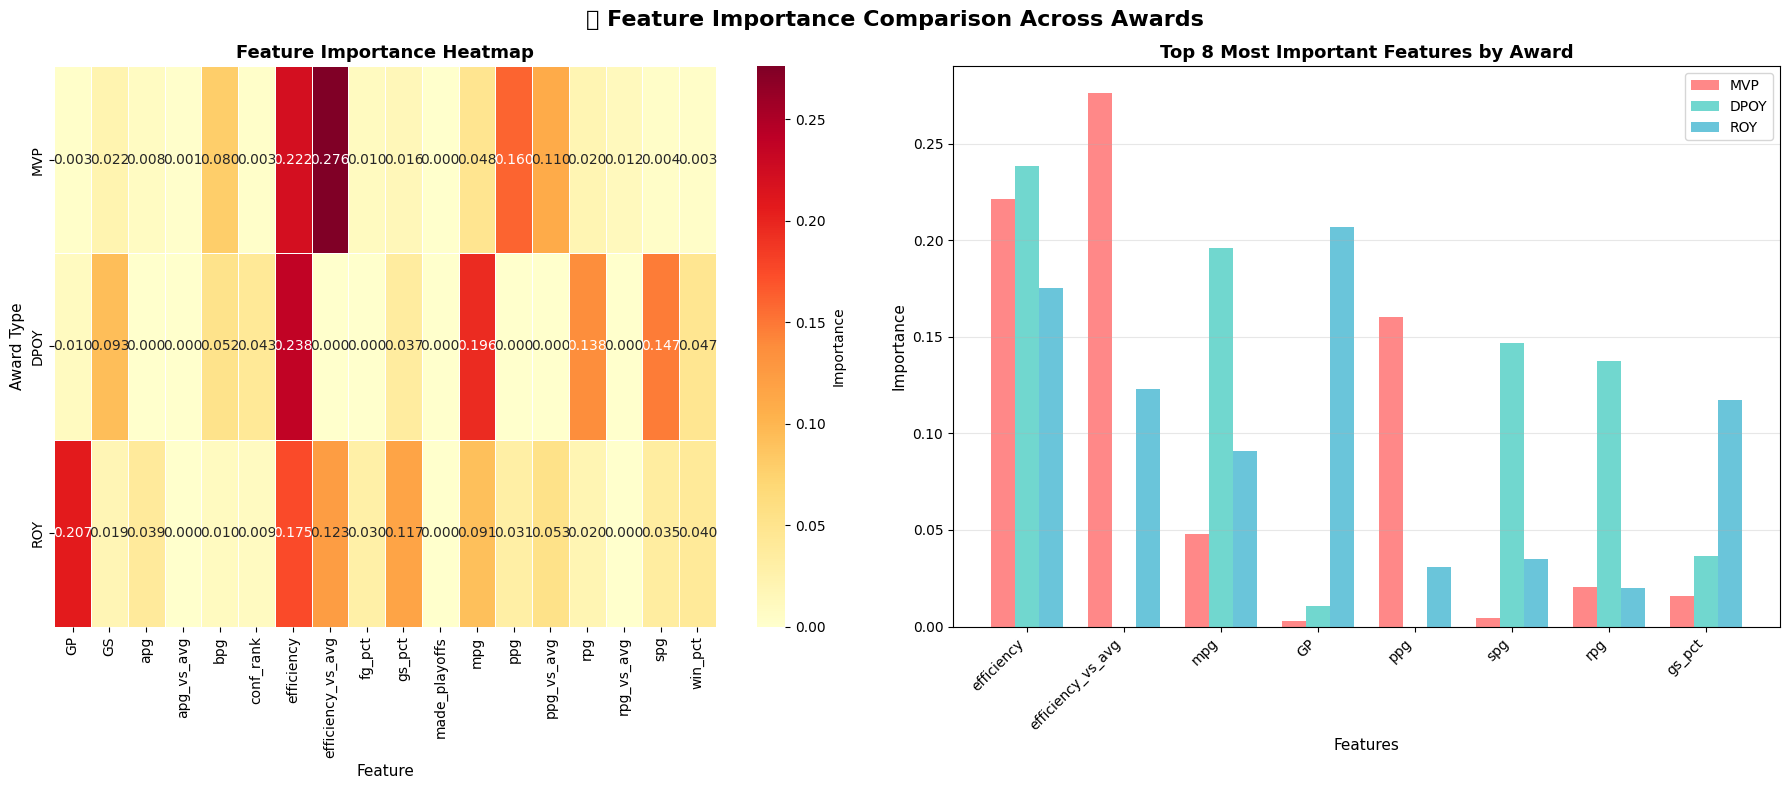


🎯 Key Insights - What Each Award Values Most:

MVP Top 3:
  1. efficiency_vs_avg: 27.6%
  2. efficiency: 22.2%
  3. ppg: 16.0%

DPOY Top 3:
  1. efficiency: 23.8%
  2. mpg: 19.6%
  3. spg: 14.7%

ROY Top 3:
  1. GP: 20.7%
  2. efficiency: 17.5%
  3. efficiency_vs_avg: 12.3%


In [31]:
# ===============================================================
# 📊 VISUALIZATION 4: Comparative Feature Importance Across Awards
# ===============================================================

# Get feature importances from all models
features_mvp = ['ppg', 'rpg', 'apg', 'spg', 'bpg', 'mpg', 'fg_pct', 'efficiency', 
                'gs_pct', 'win_pct', 'GP', 'GS', 'made_playoffs', 'conf_rank', 
                'ppg_vs_avg', 'rpg_vs_avg', 'apg_vs_avg', 'efficiency_vs_avg']
features_dpoy = ['spg', 'bpg', 'rpg', 'mpg', 'efficiency', 'gs_pct', 'win_pct', 
                 'GP', 'GS', 'made_playoffs', 'conf_rank']
features_roy = ['ppg', 'rpg', 'apg', 'spg', 'bpg', 'mpg', 'fg_pct', 'efficiency', 
                'gs_pct', 'win_pct', 'GP', 'GS', 'made_playoffs', 'conf_rank', 
                'ppg_vs_avg', 'efficiency_vs_avg']

# Create importance comparison dataframe
all_features = set(features_mvp + features_dpoy + features_roy)
importance_comparison = pd.DataFrame(index=sorted(all_features))

# Add MVP importances
mvp_imp = pd.DataFrame({
    'Feature': features_mvp,
    'MVP': model_mvp.feature_importances_
})
importance_comparison = importance_comparison.join(mvp_imp.set_index('Feature'), how='left')

# Add DPOY importances
dpoy_imp = pd.DataFrame({
    'Feature': features_dpoy,
    'DPOY': model_dpoy.feature_importances_
})
importance_comparison = importance_comparison.join(dpoy_imp.set_index('Feature'), how='left')

# Add ROY importances
roy_imp = pd.DataFrame({
    'Feature': features_roy,
    'ROY': model_roy.feature_importances_
})
importance_comparison = importance_comparison.join(roy_imp.set_index('Feature'), how='left')

# Fill NaN with 0 (feature not used in that model)
importance_comparison = importance_comparison.fillna(0)

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
fig.suptitle('🔍 Feature Importance Comparison Across Awards', fontsize=16, fontweight='bold')

# Heatmap
ax = axes[0]
sns.heatmap(importance_comparison.T, annot=True, fmt='.3f', cmap='YlOrRd', 
            cbar_kws={'label': 'Importance'}, ax=ax, linewidths=0.5)
ax.set_title('Feature Importance Heatmap', fontsize=13, fontweight='bold')
ax.set_xlabel('Feature', fontsize=11)
ax.set_ylabel('Award Type', fontsize=11)

# Top features comparison
ax = axes[1]
top_n = 8
top_features = importance_comparison.sum(axis=1).nlargest(top_n).index

plot_data = importance_comparison.loc[top_features].T
x = np.arange(len(top_features))
width = 0.25

ax.bar(x - width, plot_data.iloc[0], width, label='MVP', color='#FF6B6B', alpha=0.8)
ax.bar(x, plot_data.iloc[1], width, label='DPOY', color='#4ECDC4', alpha=0.8)
ax.bar(x + width, plot_data.iloc[2], width, label='ROY', color='#45B7D1', alpha=0.8)

ax.set_xlabel('Features', fontsize=11)
ax.set_ylabel('Importance', fontsize=11)
ax.set_title(f'Top {top_n} Most Important Features by Award', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(top_features, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n🎯 Key Insights - What Each Award Values Most:")
print("\nMVP Top 3:")
for i, (feat, val) in enumerate(mvp_imp.nlargest(3, 'MVP')[['Feature', 'MVP']].values, 1):
    print(f"  {i}. {feat}: {val:.1%}")

print("\nDPOY Top 3:")
for i, (feat, val) in enumerate(dpoy_imp.nlargest(3, 'DPOY')[['Feature', 'DPOY']].values, 1):
    print(f"  {i}. {feat}: {val:.1%}")

print("\nROY Top 3:")
for i, (feat, val) in enumerate(roy_imp.nlargest(3, 'ROY')[['Feature', 'ROY']].values, 1):
    print(f"  {i}. {feat}: {val:.1%}")

/tmp/ipykernel_2512/2612228835.py:105: UserWarning: Glyph 127922 (\N{GAME DIE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/dee/up/ac-data-mining-project/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127922 (\N{GAME DIE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


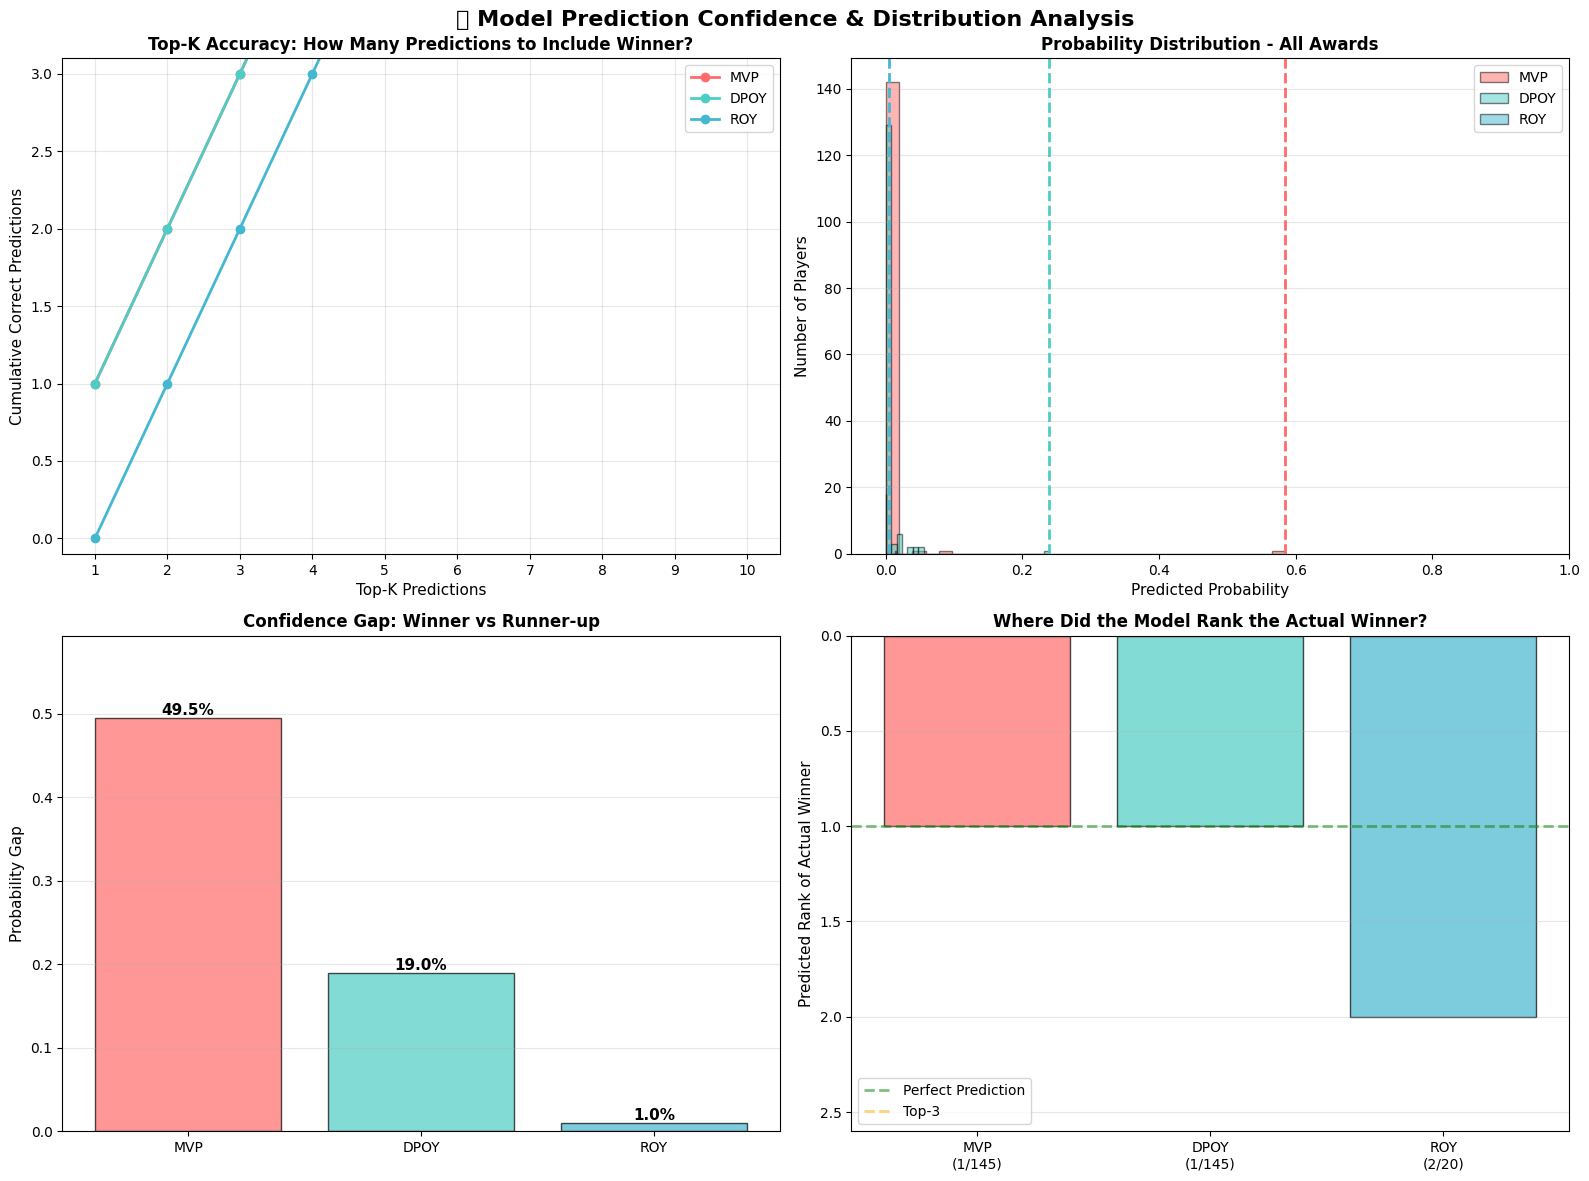


📊 Confidence Analysis Summary:

MVP:
  Top prediction confidence: 58.5%
  Confidence gap (1st - 2nd): 49.5%
  Actual winner probability: 58.5%
  Actual winner rank: #1
  Certainty: HIGH

DPOY:
  Top prediction confidence: 24.0%
  Confidence gap (1st - 2nd): 19.0%
  Actual winner probability: 24.0%
  Actual winner rank: #1
  Certainty: MODERATE

ROY:
  Top prediction confidence: 1.5%
  Confidence gap (1st - 2nd): 1.0%
  Actual winner probability: 0.5%
  Actual winner rank: #2
  Certainty: LOW


In [32]:
# ===============================================================
# 📊 VISUALIZATION 5: Prediction Confidence Analysis
# ===============================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('🎲 Model Prediction Confidence & Distribution Analysis', fontsize=16, fontweight='bold')

# Plot 1: Top-K Accuracy Curves
ax = axes[0, 0]
k_values = range(1, 11)
awards_data = [
    (mvp_pred, 'won_most_valuable_player', 'mvp_rank', 'MVP', '#FF6B6B'),
    (dpoy_pred, 'won_defensive_player_of_the_year', 'dpoy_rank', 'DPOY', '#4ECDC4'),
    (roy_pred, 'won_rookie_of_the_year', 'roy_rank', 'ROY', '#45B7D1')
]

for pred_df, target, rank_col, label, color in awards_data:
    actual_rank = pred_df[pred_df[target] == 1][rank_col].values[0]
    top_k_acc = [1 if actual_rank <= k else 0 for k in k_values]
    cumulative = np.cumsum(top_k_acc)
    ax.plot(k_values, cumulative, marker='o', linewidth=2, label=label, color=color)

ax.set_xlabel('Top-K Predictions', fontsize=11)
ax.set_ylabel('Cumulative Correct Predictions', fontsize=11)
ax.set_title('Top-K Accuracy: How Many Predictions to Include Winner?', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xticks(k_values)
ax.set_ylim(-0.1, 3.1)

# Plot 2: Probability Distribution Comparison
ax = axes[0, 1]
for pred_df, target, rank_col, label, color in awards_data:
    proba_col = f"{label.lower()}_proba"
    probabilities = pred_df[proba_col].values
    ax.hist(probabilities, bins=30, alpha=0.5, label=label, color=color, edgecolor='black')
    
    # Mark actual winner
    winner_proba = pred_df[pred_df[target] == 1][proba_col].values[0]
    ax.axvline(winner_proba, color=color, linestyle='--', linewidth=2)

ax.set_xlabel('Predicted Probability', fontsize=11)
ax.set_ylabel('Number of Players', fontsize=11)
ax.set_title('Probability Distribution - All Awards', fontsize=12, fontweight='bold')
ax.legend()
ax.set_xlim(-0.05, 1.0)
ax.grid(True, alpha=0.3, axis='y')

# Plot 3: Winner vs Runner-up Gap Analysis
ax = axes[1, 0]
gaps = []
labels_gap = []

for pred_df, target, rank_col, label, color in awards_data:
    proba_col = f"{label.lower()}_proba"
    sorted_pred = pred_df.sort_values(proba_col, ascending=False)
    
    top_1_proba = sorted_pred.iloc[0][proba_col]
    top_2_proba = sorted_pred.iloc[1][proba_col]
    gap = top_1_proba - top_2_proba
    
    gaps.append(gap)
    labels_gap.append(label)

bars = ax.bar(labels_gap, gaps, color=['#FF6B6B', '#4ECDC4', '#45B7D1'], alpha=0.7, edgecolor='black')
ax.set_ylabel('Probability Gap', fontsize=11)
ax.set_title('Confidence Gap: Winner vs Runner-up', fontsize=12, fontweight='bold')
ax.set_ylim(0, max(gaps) * 1.2)
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, gap in zip(bars, gaps):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{gap:.1%}',
            ha='center', va='bottom', fontweight='bold', fontsize=11)

# Plot 4: Ranking Distribution (where did winner land?)
ax = axes[1, 1]
winner_ranks = []
total_candidates = []
labels_rank = []

for pred_df, target, rank_col, label, color in awards_data:
    actual_rank = pred_df[pred_df[target] == 1][rank_col].values[0]
    total = len(pred_df)
    
    winner_ranks.append(actual_rank)
    total_candidates.append(total)
    labels_rank.append(f"{label}\n({int(actual_rank)}/{total})")

x_pos = np.arange(len(labels_rank))
bars = ax.bar(x_pos, winner_ranks, color=['#FF6B6B', '#4ECDC4', '#45B7D1'], alpha=0.7, edgecolor='black')
ax.set_ylabel('Predicted Rank of Actual Winner', fontsize=11)
ax.set_title('Where Did the Model Rank the Actual Winner?', fontsize=12, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels_rank)
ax.axhline(y=1, color='green', linestyle='--', linewidth=2, label='Perfect Prediction', alpha=0.5)
ax.axhline(y=3, color='orange', linestyle='--', linewidth=2, label='Top-3', alpha=0.5)
ax.set_ylim(0, max(winner_ranks) * 1.3)
ax.invert_yaxis()  # Lower rank is better
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n📊 Confidence Analysis Summary:")
for pred_df, target, rank_col, label, color in awards_data:
    proba_col = f"{label.lower()}_proba"
    sorted_pred = pred_df.sort_values(proba_col, ascending=False)
    
    top_1_proba = sorted_pred.iloc[0][proba_col]
    top_2_proba = sorted_pred.iloc[1][proba_col]
    gap = top_1_proba - top_2_proba
    
    winner_proba = pred_df[pred_df[target] == 1][proba_col].values[0]
    actual_rank = pred_df[pred_df[target] == 1][rank_col].values[0]
    
    print(f"\n{label}:")
    print(f"  Top prediction confidence: {top_1_proba:.1%}")
    print(f"  Confidence gap (1st - 2nd): {gap:.1%}")
    print(f"  Actual winner probability: {winner_proba:.1%}")
    print(f"  Actual winner rank: #{int(actual_rank)}")
    print(f"  Certainty: {'HIGH' if gap > 0.3 else 'MODERATE' if gap > 0.1 else 'LOW'}")

/tmp/ipykernel_2512/3262213527.py:98: UserWarning: Glyph 127936 (\N{BASKETBALL AND HOOP}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/dee/up/ac-data-mining-project/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127936 (\N{BASKETBALL AND HOOP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


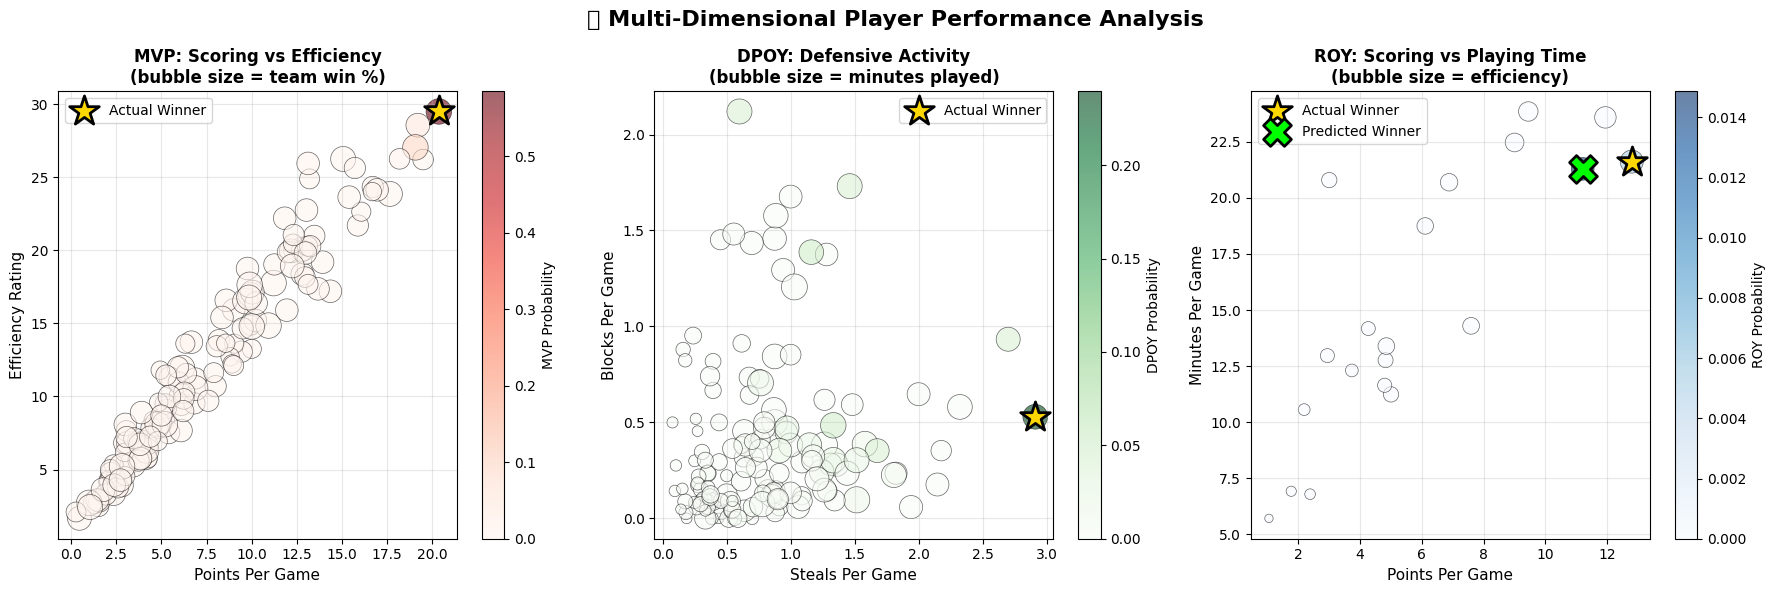


🎯 Performance Quadrant Analysis:

MVP (High Efficiency + High Scoring):
  Elite performers: 32
  Winner in this quadrant: YES

DPOY (High Activity = SPG + BPG):
  High activity defenders: 35
  Winner in this group: YES

ROY (High Usage = PPG + MPG):
  High usage rookies: 5
  Winner in this group: YES


In [33]:
# ===============================================================
# 📊 VISUALIZATION 6: Multi-Dimensional Performance Scatter
# ===============================================================

fig = plt.figure(figsize=(18, 6))
fig.suptitle('🏀 Multi-Dimensional Player Performance Analysis', fontsize=16, fontweight='bold')

# MVP: Efficiency vs Scoring (bubble size = win%)
ax1 = plt.subplot(131)
scatter1 = ax1.scatter(
    mvp_pred['ppg'],
    mvp_pred['efficiency'],
    s=mvp_pred['win_pct'] * 500,
    c=mvp_pred['mvp_proba'],
    cmap='Reds',
    alpha=0.6,
    edgecolors='black',
    linewidth=0.5
)
# Highlight winner
winner = mvp_pred[mvp_pred['won_most_valuable_player'] == 1]
ax1.scatter(winner['ppg'], winner['efficiency'], s=500, c='gold', marker='*', 
           edgecolors='black', linewidth=2, label='Actual Winner', zorder=10)
# Highlight predicted
predicted = mvp_pred.nsmallest(1, 'mvp_rank')
if predicted['playerID'].values[0] != winner['playerID'].values[0]:
    ax1.scatter(predicted['ppg'], predicted['efficiency'], s=400, c='lime', marker='X', 
               edgecolors='black', linewidth=2, label='Predicted Winner', zorder=9)

ax1.set_xlabel('Points Per Game', fontsize=11)
ax1.set_ylabel('Efficiency Rating', fontsize=11)
ax1.set_title('MVP: Scoring vs Efficiency\n(bubble size = team win %)', fontsize=12, fontweight='bold')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)
cbar1 = plt.colorbar(scatter1, ax=ax1)
cbar1.set_label('MVP Probability', fontsize=10)

# DPOY: Steals vs Blocks (bubble size = minutes)
ax2 = plt.subplot(132)
scatter2 = ax2.scatter(
    dpoy_pred['spg'],
    dpoy_pred['bpg'],
    s=dpoy_pred['mpg'] * 10,
    c=dpoy_pred['dpoy_proba'],
    cmap='Greens',
    alpha=0.6,
    edgecolors='black',
    linewidth=0.5
)
# Highlight winner
winner = dpoy_pred[dpoy_pred['won_defensive_player_of_the_year'] == 1]
ax2.scatter(winner['spg'], winner['bpg'], s=500, c='gold', marker='*', 
           edgecolors='black', linewidth=2, label='Actual Winner', zorder=10)
# Highlight predicted
predicted = dpoy_pred.nsmallest(1, 'dpoy_rank')
if predicted['playerID'].values[0] != winner['playerID'].values[0]:
    ax2.scatter(predicted['spg'], predicted['bpg'], s=400, c='lime', marker='X', 
               edgecolors='black', linewidth=2, label='Predicted Winner', zorder=9)

ax2.set_xlabel('Steals Per Game', fontsize=11)
ax2.set_ylabel('Blocks Per Game', fontsize=11)
ax2.set_title('DPOY: Defensive Activity\n(bubble size = minutes played)', fontsize=12, fontweight='bold')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)
cbar2 = plt.colorbar(scatter2, ax=ax2)
cbar2.set_label('DPOY Probability', fontsize=10)

# ROY: Scoring vs Playing Time (bubble size = efficiency)
ax3 = plt.subplot(133)
scatter3 = ax3.scatter(
    roy_pred['ppg'],
    roy_pred['mpg'],
    s=roy_pred['efficiency'] * 15,
    c=roy_pred['roy_proba'],
    cmap='Blues',
    alpha=0.6,
    edgecolors='black',
    linewidth=0.5
)
# Highlight winner
winner = roy_pred[roy_pred['won_rookie_of_the_year'] == 1]
ax3.scatter(winner['ppg'], winner['mpg'], s=500, c='gold', marker='*', 
           edgecolors='black', linewidth=2, label='Actual Winner', zorder=10)
# Highlight predicted
predicted = roy_pred.nsmallest(1, 'roy_rank')
if predicted['playerID'].values[0] != winner['playerID'].values[0]:
    ax3.scatter(predicted['ppg'], predicted['mpg'], s=400, c='lime', marker='X', 
               edgecolors='black', linewidth=2, label='Predicted Winner', zorder=9)

ax3.set_xlabel('Points Per Game', fontsize=11)
ax3.set_ylabel('Minutes Per Game', fontsize=11)
ax3.set_title('ROY: Scoring vs Playing Time\n(bubble size = efficiency)', fontsize=12, fontweight='bold')
ax3.legend(loc='upper left')
ax3.grid(True, alpha=0.3)
cbar3 = plt.colorbar(scatter3, ax=ax3)
cbar3.set_label('ROY Probability', fontsize=10)

plt.tight_layout()
plt.show()

print("\n🎯 Performance Quadrant Analysis:")
print("\nMVP (High Efficiency + High Scoring):")
mvp_elite = mvp_pred[(mvp_pred['ppg'] > mvp_pred['ppg'].quantile(0.75)) & 
                      (mvp_pred['efficiency'] > mvp_pred['efficiency'].quantile(0.75))]
print(f"  Elite performers: {len(mvp_elite)}")
print(f"  Winner in this quadrant: {'YES' if mvp_pred[mvp_pred['won_most_valuable_player']==1]['ppg'].values[0] > mvp_pred['ppg'].quantile(0.75) else 'NO'}")

print("\nDPOY (High Activity = SPG + BPG):")
dpoy_pred['defensive_activity'] = dpoy_pred['spg'] + dpoy_pred['bpg']
dpoy_elite = dpoy_pred[dpoy_pred['defensive_activity'] > dpoy_pred['defensive_activity'].quantile(0.75)]
print(f"  High activity defenders: {len(dpoy_elite)}")
print(f"  Winner in this group: {'YES' if dpoy_pred[dpoy_pred['won_defensive_player_of_the_year']==1]['defensive_activity'].values[0] > dpoy_pred['defensive_activity'].quantile(0.75) else 'NO'}")

print("\nROY (High Usage = PPG + MPG):")
roy_pred['usage'] = roy_pred['ppg'] + roy_pred['mpg']
roy_elite = roy_pred[roy_pred['usage'] > roy_pred['usage'].quantile(0.75)]
print(f"  High usage rookies: {len(roy_elite)}")
print(f"  Winner in this group: {'YES' if roy_pred[roy_pred['won_rookie_of_the_year']==1]['usage'].values[0] > roy_pred['usage'].quantile(0.75) else 'NO'}")

/tmp/ipykernel_2512/2902584847.py:45: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/dee/up/ac-data-mining-project/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


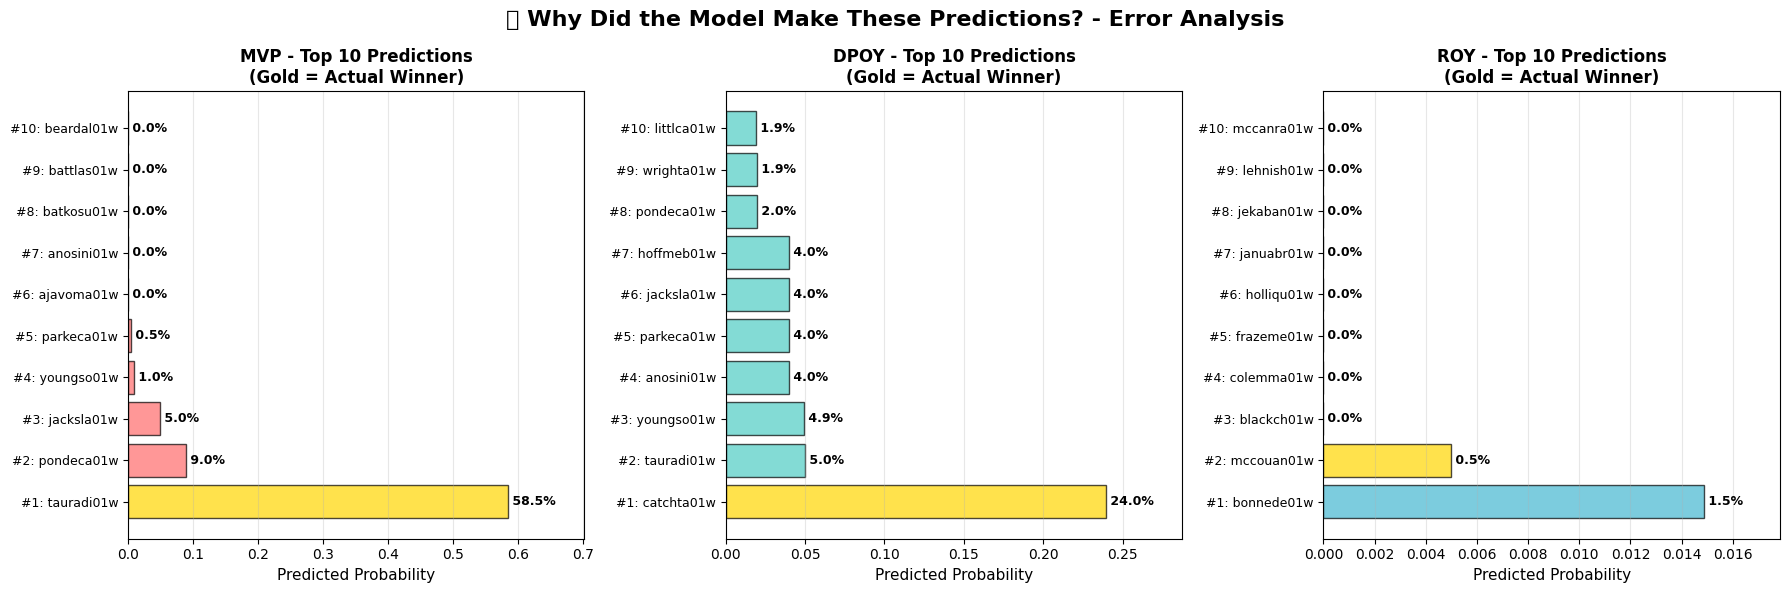


🔬 Detailed Error Analysis:


MVP ANALYSIS:
Result: ✓ CORRECT PREDICTION

✓ Model correctly identified: tauradi01w (PHO)
  Confidence: 58.50%
  Key Stats: 20.4 PPG, 29.5 EFF, 67.6% Win%

DPOY ANALYSIS:
Result: ✓ CORRECT PREDICTION

✓ Model correctly identified: catchta01w (IND)
  Confidence: 23.97%
  Key Stats: 15.1 PPG, 26.3 EFF, 64.7% Win%

ROY ANALYSIS:
Result: ✗ INCORRECT PREDICTION

🎯 PREDICTED WINNER:
  Player: bonnede01w (PHO)
  Probability: 1.49%
  Key Stats: 11.2 PPG, 17.8 EFF, 67.6% Win%

⭐ ACTUAL WINNER:
  Player: mccouan01w (ATL)
  Probability: 0.50%
  Rank: #2
  Key Stats: 12.8 PPG, 18.4 EFF, 52.9% Win%

📊 WHY THE DISCREPANCY?
  • PPG: ACTUAL has advantage (1.59 difference)
  • EFFICIENCY: ACTUAL has advantage (0.62 difference)
  • WIN_PCT: PREDICTED has advantage (0.15 difference)
  • MPG: ACTUAL has advantage (0.32 difference)


In [34]:
# ===============================================================
# 📊 VISUALIZATION 7: Misclassification Analysis (Learning from Errors)
# ===============================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('🔍 Why Did the Model Make These Predictions? - Error Analysis', fontsize=16, fontweight='bold')

# Analyze each award
awards_analysis = [
    (mvp_pred, 'won_most_valuable_player', 'mvp_rank', 'mvp_proba', 'MVP', '#FF6B6B', axes[0]),
    (dpoy_pred, 'won_defensive_player_of_the_year', 'dpoy_rank', 'dpoy_proba', 'DPOY', '#4ECDC4', axes[1]),
    (roy_pred, 'won_rookie_of_the_year', 'roy_rank', 'roy_proba', 'ROY', '#45B7D1', axes[2])
]

for pred_df, target, rank_col, proba_col, label, color, ax in awards_analysis:
    # Get top 10 predictions
    top_10 = pred_df.nsmallest(10, rank_col)
    
    # Create visualization
    ranks = top_10[rank_col].values
    probas = top_10[proba_col].values
    is_winner = top_10[target].values
    player_ids = top_10['playerID'].values
    
    # Color bars: gold for actual winner, others in gradient
    bar_colors = ['gold' if w == 1 else color for w in is_winner]
    
    bars = ax.barh(range(len(ranks)), probas, color=bar_colors, alpha=0.7, edgecolor='black')
    
    # Add labels
    ax.set_yticks(range(len(ranks)))
    ax.set_yticklabels([f"#{int(r)}: {pid}" for r, pid in zip(ranks, player_ids)], fontsize=9)
    ax.set_xlabel('Predicted Probability', fontsize=11)
    ax.set_title(f'{label} - Top 10 Predictions\n(Gold = Actual Winner)', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')
    ax.set_xlim(0, max(probas) * 1.2)
    
    # Add probability values on bars
    for i, (bar, prob) in enumerate(zip(bars, probas)):
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2,
                f' {prob:.1%}',
                ha='left', va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

# Detailed misclassification analysis
print("\n🔬 Detailed Error Analysis:\n")

for pred_df, target, rank_col, proba_col, label, color, _ in awards_analysis:
    actual_winner = pred_df[pred_df[target] == 1].iloc[0]
    predicted_winner = pred_df.nsmallest(1, rank_col).iloc[0]
    
    is_correct = actual_winner['playerID'] == predicted_winner['playerID']
    
    print(f"\n{'='*60}")
    print(f"{label} ANALYSIS:")
    print(f"{'='*60}")
    print(f"Result: {'✓ CORRECT PREDICTION' if is_correct else '✗ INCORRECT PREDICTION'}")
    
    if not is_correct:
        print(f"\n🎯 PREDICTED WINNER:")
        print(f"  Player: {predicted_winner['playerID']} ({predicted_winner['tmID']})")
        print(f"  Probability: {predicted_winner[proba_col]:.2%}")
        print(f"  Key Stats: {predicted_winner['ppg']:.1f} PPG, {predicted_winner['efficiency']:.1f} EFF, {predicted_winner['win_pct']:.1%} Win%")
        
        print(f"\n⭐ ACTUAL WINNER:")
        print(f"  Player: {actual_winner['playerID']} ({actual_winner['tmID']})")
        print(f"  Probability: {actual_winner[proba_col]:.2%}")
        print(f"  Rank: #{int(actual_winner[rank_col])}")
        print(f"  Key Stats: {actual_winner['ppg']:.1f} PPG, {actual_winner['efficiency']:.1f} EFF, {actual_winner['win_pct']:.1%} Win%")
        
        print(f"\n📊 WHY THE DISCREPANCY?")
        # Compare key metrics
        stat_comparisons = []
        for stat in ['ppg', 'efficiency', 'win_pct', 'mpg']:
            pred_val = predicted_winner.get(stat, 0)
            actual_val = actual_winner.get(stat, 0)
            diff = pred_val - actual_val
            if abs(diff) > 0.01:  # Only show meaningful differences
                winner = "PREDICTED" if diff > 0 else "ACTUAL"
                stat_comparisons.append(f"  • {stat.upper()}: {winner} has advantage ({abs(diff):.2f} difference)")
        
        if stat_comparisons:
            for comp in stat_comparisons:
                print(comp)
        else:
            print("  • Very similar statistical profiles - close call!")
    else:
        print(f"\n✓ Model correctly identified: {actual_winner['playerID']} ({actual_winner['tmID']})")
        print(f"  Confidence: {actual_winner[proba_col]:.2%}")
        print(f"  Key Stats: {actual_winner['ppg']:.1f} PPG, {actual_winner['efficiency']:.1f} EFF, {actual_winner['win_pct']:.1%} Win%")